In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
from datetime import datetime
from collections import OrderedDict
from toolz.curried import pipe, curry, compose
warnings.filterwarnings('ignore')

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
import chnet.ch_tools as ch_tools
import chnet.utilities as ch_utils
import chnet.ch_generator as ch_gen
from chnet.torchsummary import summary
from chnet.ch_loader import CahnHillDataset

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## Loss Functions

In [6]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

def get_primes(n):
    # https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    sieve[0] = False
    for i in range(int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[      ((k*k)//3)      ::2*k] = False
            sieve[(k*k+4*k-2*k*(i&1))//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0]+1)|1)]

# Set Device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [8]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32, 
             temporal=3).to(device)

summary(model, input_size=(10,1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Padder-1            [-1, 1, 98, 98]               0
            Conv2d-2           [-1, 32, 96, 96]             288
       BatchNorm2d-3           [-1, 32, 96, 96]              64
              ReLU-4           [-1, 32, 96, 96]               0
            Padder-5           [-1, 32, 98, 98]               0
            Conv2d-6           [-1, 32, 96, 96]           9,216
       BatchNorm2d-7           [-1, 32, 96, 96]              64
              ReLU-8           [-1, 32, 96, 96]               0
         AvgPool2d-9           [-1, 32, 48, 48]               0
           Padder-10           [-1, 32, 50, 50]               0
           Conv2d-11           [-1, 64, 48, 48]          18,432
      BatchNorm2d-12           [-1, 64, 48, 48]             128
             ReLU-13           [-1, 64, 48, 48]               0
           Padder-14           [-1, 64,

(tensor(23288163), tensor(23288163))

# Data Generator

In [9]:
x_data, y_data = ch_gen.data_generator(nsamples=4, 
                                       dim_x=64, 
                                       init_steps=1, 
                                       delta_sim_steps=100,
                                       dx=0.25, 
                                       dt=0.01,
                                       gamma=1.0,
                                       n_step=10,
                                       seed = None,
                                       device=device)

print(x_data.shape)
print(y_data.shape)

(4, 10, 64, 64)
(4, 10, 64, 64)


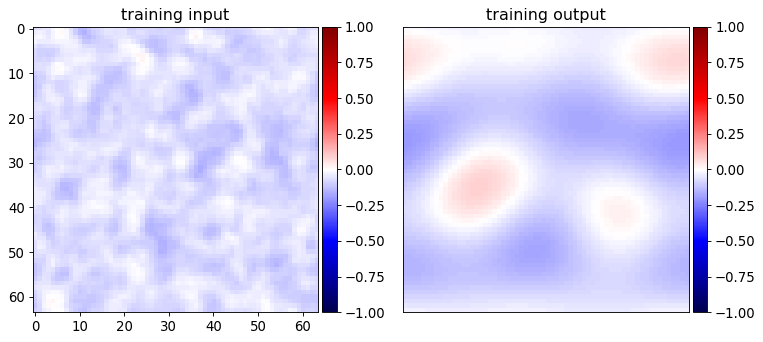

In [10]:
im_x = x_data[0, 0]
im_y = y_data[0, -1]
ch_utils.draw_by_side([im_x, im_y], sub_titles=["training input", "training output"])

In [11]:
transformer_x = lambda x: x[:,None]
transformer_y = lambda x: x[:,None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print("\n", x.shape, "\n", y.shape)


 torch.Size([1, 10, 1, 64, 64]) 
 torch.Size([1, 10, 1, 64, 64])


In [12]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32, 
             temporal=10).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1547, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [7]:
## Process Parameters
dim_x=96

init_steps=1
delta_sim_steps=1000

n_step = 5
dx = 0.25 
dt = 0.01
gamma=1.0
m_l=-0.05, 
m_r=+0.05,


seed_trn = 110364
n_samples_trn = 1024
ngf = 32

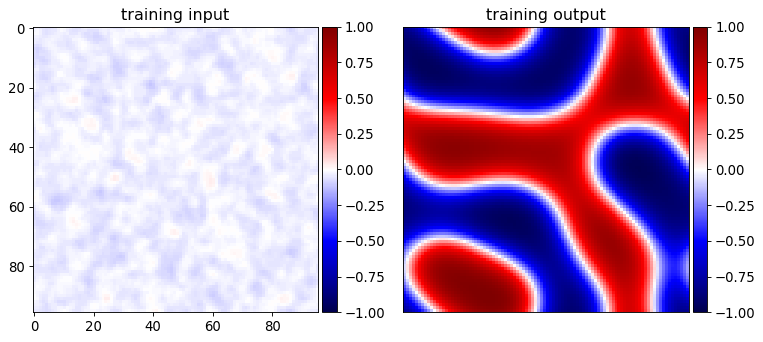

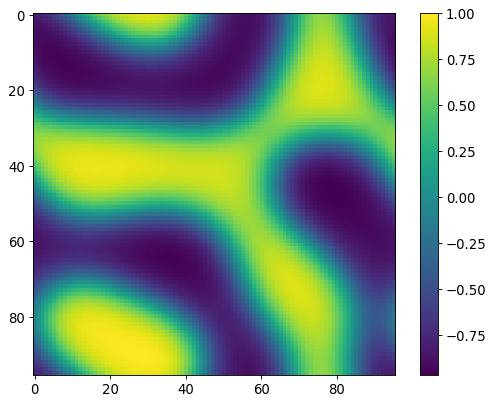

CPU times: user 12.8 s, sys: 9.55 s, total: 22.4 s
Wall time: 20.8 s


In [15]:
%%time
x_trn, y_trn = ch_gen.data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx=dx, 
                              dt=dt,
                              m_l=m_l, 
                              m_r=m_r,
                              n_step=n_step,
                              gamma=gamma, 
                              seed=2513,
                              device=device)

ch_utils.draw_by_side([x_trn[0][0], y_trn[0][-1]], sub_titles=["training input", "training output"])

In [16]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, out_channels=1, init_features=ngf, temporal=n_step).double().to(device)


trn_losses = []
val_losses = []

In [17]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def mse_loss_steps(y1, y2, steps, scale=1.):
    """standard MSE definition"""
    
    loss = 0.0
    for t in range(steps):
        loss += ((y1[:,t] - y2[:,t]) ** 2).sum() / y1[:,t].data.nelement() * scale
    return loss

In [18]:
criterion = mse_loss_steps(steps=n_step, scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
primes = get_primes(1000)[:100]

print("No. of datasets: {}".format(len(primes)))

for num, prime in enumerate(primes):
    # Loss and optimizer
    x_trn, y_trn = ch_gen.data_generator(nsamples=n_samples_trn, 
                                  dim_x=dim_x, 
                                  init_steps=init_steps, 
                                  delta_sim_steps = delta_sim_steps,
                                  dx=dx, 
                                  dt=dt,
                                  m_l=m_l, 
                                  m_r=m_r,
                                  n_step=n_step,
                                  gamma=gamma, 
                                  seed=2513*prime,
                                  device = device)


    trn_dataset = CahnHillDataset(x_trn, y_trn, 
                                  transform_x=lambda x: x[:,None], 
                                  transform_y=lambda x: x[:,None])
    
    trn_loader = DataLoader(trn_dataset, 
                            batch_size=8, 
                            shuffle=True, 
                            num_workers=4)
    
    print("Training Run: {}, prime: {}".format(num, prime))
    
    total_step = len(trn_loader)
    
    for epoch in range(num_epochs):  
        torch.save(model.state_dict(), "out/unet_pytorch_ch{}_{}_{}_loop.pt".format(ngf, init_steps, delta_sim_steps))
        for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):

            model.train()

            x = item_trn['x'].to(device)
            y_tru = item_trn['y'].to(device)

            # Forward pass
#             y_prd = model(x)
#             loss = criterion(y_tru, y_prd)
            
            loss = 0.0
            for t in range(n_step):
                y_prd = model.unets[t](x[:,t])
                loss = loss + mse_loss(y_tru[:,t], y_prd, scale=10000)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_losses.append(np.sqrt(loss.item()))

            if (i) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}'.format(epoch+1, 
                                                                                     num_epochs, 
                                                                                     i+1, 
                                                                                     total_step, 
                                                                                     np.mean(trn_losses[-16:])))

No. of datasets: 100
Training Run: 0, prime: 2


Epoch [1/5], Step [1/128], Training Loss: 120.10630840763
Epoch [1/5], Step [51/128], Training Loss: 65.52656986842
Epoch [1/5], Step [101/128], Training Loss: 49.30529296252



Epoch [2/5], Step [1/128], Training Loss: 43.78810219357
Epoch [2/5], Step [51/128], Training Loss: 36.73011631385
Epoch [2/5], Step [101/128], Training Loss: 31.64379388720



Epoch [3/5], Step [1/128], Training Loss: 29.27294024362
Epoch [3/5], Step [51/128], Training Loss: 24.91406201921
Epoch [3/5], Step [101/128], Training Loss: 22.07566050523



Epoch [4/5], Step [1/128], Training Loss: 21.55875992181
Epoch [4/5], Step [51/128], Training Loss: 18.82424001442
Epoch [4/5], Step [101/128], Training Loss: 17.38093455308



Epoch [5/5], Step [1/128], Training Loss: 16.68960409159
Epoch [5/5], Step [51/128], Training Loss: 15.34836613661
Epoch [5/5], Step [101/128], Training Loss: 14.61267714148

Training Run: 1, prime: 3


Epoch [1/5], Step [1/128], Training Loss: 14.28275227484
Epoch [1/5], Step [51/128], Training Loss: 13.32180851581
Epoch [1/5], Step [101/128], Training Loss: 13.13237533062



Epoch [2/5], Step [1/128], Training Loss: 12.66778986829
Epoch [2/5], Step [51/128], Training Loss: 11.70597203654
Epoch [2/5], Step [101/128], Training Loss: 12.10151405030



Epoch [3/5], Step [1/128], Training Loss: 11.76421761212
Epoch [3/5], Step [51/128], Training Loss: 11.20721129300
Epoch [3/5], Step [101/128], Training Loss: 10.98148162297



Epoch [4/5], Step [1/128], Training Loss: 10.82595148078
Epoch [4/5], Step [51/128], Training Loss: 10.60542612662
Epoch [4/5], Step [101/128], Training Loss: 10.01105000122



Epoch [5/5], Step [1/128], Training Loss: 10.20288803799
Epoch [5/5], Step [51/128], Training Loss: 9.87209822921
Epoch [5/5], Step [101/128], Training Loss: 9.85904026063

Training Run: 2, prime: 5


Epoch [1/5], Step [1/128], Training Loss: 9.35402350725
Epoch [1/5], Step [51/128], Training Loss: 9.93372959188
Epoch [1/5], Step [101/128], Training Loss: 9.59846094988



Epoch [2/5], Step [1/128], Training Loss: 9.25596123805
Epoch [2/5], Step [51/128], Training Loss: 9.24728797686
Epoch [2/5], Step [101/128], Training Loss: 9.03937229749



Epoch [3/5], Step [1/128], Training Loss: 8.86466821847
Epoch [3/5], Step [51/128], Training Loss: 8.63920745910
Epoch [3/5], Step [101/128], Training Loss: 8.75876000012



Epoch [4/5], Step [1/128], Training Loss: 8.55627560429
Epoch [4/5], Step [51/128], Training Loss: 8.71347351544
Epoch [4/5], Step [101/128], Training Loss: 8.11577020449



Epoch [5/5], Step [1/128], Training Loss: 8.08900993889
Epoch [5/5], Step [51/128], Training Loss: 8.05935037542
Epoch [5/5], Step [101/128], Training Loss: 7.77736474514

Training Run: 3, prime: 7


Epoch [1/5], Step [1/128], Training Loss: 7.53804926762
Epoch [1/5], Step [51/128], Training Loss: 7.85514595178
Epoch [1/5], Step [101/128], Training Loss: 7.54776710403



Epoch [2/5], Step [1/128], Training Loss: 7.90054759017
Epoch [2/5], Step [51/128], Training Loss: 7.66449016434
Epoch [2/5], Step [101/128], Training Loss: 7.81308206310



Epoch [3/5], Step [1/128], Training Loss: 7.51491339858
Epoch [3/5], Step [51/128], Training Loss: 7.52136954017
Epoch [3/5], Step [101/128], Training Loss: 7.50611052968



Epoch [4/5], Step [1/128], Training Loss: 7.32470388886
Epoch [4/5], Step [51/128], Training Loss: 7.47296294894
Epoch [4/5], Step [101/128], Training Loss: 6.96028207609



Epoch [5/5], Step [1/128], Training Loss: 6.78920691938
Epoch [5/5], Step [51/128], Training Loss: 6.83228594575
Epoch [5/5], Step [101/128], Training Loss: 6.87518839008

Training Run: 4, prime: 11


Epoch [1/5], Step [1/128], Training Loss: 6.78034250899
Epoch [1/5], Step [51/128], Training Loss: 6.89887525688
Epoch [1/5], Step [101/128], Training Loss: 6.84572113569



Epoch [2/5], Step [1/128], Training Loss: 6.88054660291
Epoch [2/5], Step [51/128], Training Loss: 7.10663861054
Epoch [2/5], Step [101/128], Training Loss: 6.90718964830



Epoch [3/5], Step [1/128], Training Loss: 6.74536267570
Epoch [3/5], Step [51/128], Training Loss: 7.16901570082
Epoch [3/5], Step [101/128], Training Loss: 6.54274225657



Epoch [4/5], Step [1/128], Training Loss: 6.29548099196
Epoch [4/5], Step [51/128], Training Loss: 7.10603182346
Epoch [4/5], Step [101/128], Training Loss: 6.44229034130



Epoch [5/5], Step [1/128], Training Loss: 6.43505800288
Epoch [5/5], Step [51/128], Training Loss: 6.45850070350
Epoch [5/5], Step [101/128], Training Loss: 6.24448816657

Training Run: 5, prime: 13


Epoch [1/5], Step [1/128], Training Loss: 6.28880084103
Epoch [1/5], Step [51/128], Training Loss: 6.44513991734
Epoch [1/5], Step [101/128], Training Loss: 5.86089236321



Epoch [2/5], Step [1/128], Training Loss: 6.22649766499
Epoch [2/5], Step [51/128], Training Loss: 6.01952549439
Epoch [2/5], Step [101/128], Training Loss: 6.16471653249



Epoch [3/5], Step [1/128], Training Loss: 5.99704184086
Epoch [3/5], Step [51/128], Training Loss: 5.94865092713
Epoch [3/5], Step [101/128], Training Loss: 6.05390295314



Epoch [4/5], Step [1/128], Training Loss: 6.10929118611
Epoch [4/5], Step [51/128], Training Loss: 5.59462305297
Epoch [4/5], Step [101/128], Training Loss: 5.68495415404



Epoch [5/5], Step [1/128], Training Loss: 5.72592237241
Epoch [5/5], Step [51/128], Training Loss: 5.49043869529
Epoch [5/5], Step [101/128], Training Loss: 5.51170707913

Training Run: 6, prime: 17


Epoch [1/5], Step [1/128], Training Loss: 5.56887280159
Epoch [1/5], Step [51/128], Training Loss: 5.86008149317
Epoch [1/5], Step [101/128], Training Loss: 6.20393962016



Epoch [2/5], Step [1/128], Training Loss: 5.82968808754
Epoch [2/5], Step [51/128], Training Loss: 5.44641124055
Epoch [2/5], Step [101/128], Training Loss: 6.02187840906



Epoch [3/5], Step [1/128], Training Loss: 5.47942218307
Epoch [3/5], Step [51/128], Training Loss: 5.81767396470
Epoch [3/5], Step [101/128], Training Loss: 5.88098896848



Epoch [4/5], Step [1/128], Training Loss: 5.32136696596
Epoch [4/5], Step [51/128], Training Loss: 5.31487845838
Epoch [4/5], Step [101/128], Training Loss: 5.85384252891



Epoch [5/5], Step [1/128], Training Loss: 5.58925296061
Epoch [5/5], Step [51/128], Training Loss: 5.10851150020
Epoch [5/5], Step [101/128], Training Loss: 5.54137410957

Training Run: 7, prime: 19


Epoch [1/5], Step [1/128], Training Loss: 5.91781378657
Epoch [1/5], Step [51/128], Training Loss: 5.58828999884
Epoch [1/5], Step [101/128], Training Loss: 5.38972667817



Epoch [2/5], Step [1/128], Training Loss: 5.73409163459
Epoch [2/5], Step [51/128], Training Loss: 5.98258224513
Epoch [2/5], Step [101/128], Training Loss: 5.27216269892



Epoch [3/5], Step [1/128], Training Loss: 5.58626893435
Epoch [3/5], Step [51/128], Training Loss: 5.65425181379
Epoch [3/5], Step [101/128], Training Loss: 5.51757862470



Epoch [4/5], Step [1/128], Training Loss: 5.03586317536
Epoch [4/5], Step [51/128], Training Loss: 5.30164055479
Epoch [4/5], Step [101/128], Training Loss: 5.11877897517



Epoch [5/5], Step [1/128], Training Loss: 4.61137867140
Epoch [5/5], Step [51/128], Training Loss: 5.19760962192
Epoch [5/5], Step [101/128], Training Loss: 4.80310565707

Training Run: 8, prime: 23


Epoch [1/5], Step [1/128], Training Loss: 4.95152045101
Epoch [1/5], Step [51/128], Training Loss: 4.94982943212
Epoch [1/5], Step [101/128], Training Loss: 5.35350391968



Epoch [2/5], Step [1/128], Training Loss: 5.26846942738
Epoch [2/5], Step [51/128], Training Loss: 4.83487478119
Epoch [2/5], Step [101/128], Training Loss: 4.77558084320



Epoch [3/5], Step [1/128], Training Loss: 5.03632963485
Epoch [3/5], Step [51/128], Training Loss: 4.93376940052
Epoch [3/5], Step [101/128], Training Loss: 4.60108695755



Epoch [4/5], Step [1/128], Training Loss: 4.79819318047
Epoch [4/5], Step [51/128], Training Loss: 5.05046448703
Epoch [4/5], Step [101/128], Training Loss: 4.86801438793



Epoch [5/5], Step [1/128], Training Loss: 4.69836131185
Epoch [5/5], Step [51/128], Training Loss: 4.83235249827
Epoch [5/5], Step [101/128], Training Loss: 4.67622925038

Training Run: 9, prime: 29


Epoch [1/5], Step [1/128], Training Loss: 4.52997680260
Epoch [1/5], Step [51/128], Training Loss: 4.98984736613
Epoch [1/5], Step [101/128], Training Loss: 4.66477680353



Epoch [2/5], Step [1/128], Training Loss: 4.45564912310
Epoch [2/5], Step [51/128], Training Loss: 4.65253496604
Epoch [2/5], Step [101/128], Training Loss: 4.60416915879



Epoch [3/5], Step [1/128], Training Loss: 4.59597756125
Epoch [3/5], Step [51/128], Training Loss: 4.65391039238
Epoch [3/5], Step [101/128], Training Loss: 4.65971120782



Epoch [4/5], Step [1/128], Training Loss: 4.57208673475
Epoch [4/5], Step [51/128], Training Loss: 4.78528604361
Epoch [4/5], Step [101/128], Training Loss: 4.34442692683



Epoch [5/5], Step [1/128], Training Loss: 4.56617456464
Epoch [5/5], Step [51/128], Training Loss: 4.19617404173
Epoch [5/5], Step [101/128], Training Loss: 5.13810998602

Training Run: 10, prime: 31


Epoch [1/5], Step [1/128], Training Loss: 4.36510858124
Epoch [1/5], Step [51/128], Training Loss: 4.46984502073
Epoch [1/5], Step [101/128], Training Loss: 4.45508687093



Epoch [2/5], Step [1/128], Training Loss: 4.16087121682
Epoch [2/5], Step [51/128], Training Loss: 4.08154520340
Epoch [2/5], Step [101/128], Training Loss: 4.05923296490



Epoch [3/5], Step [1/128], Training Loss: 4.31383447726
Epoch [3/5], Step [51/128], Training Loss: 4.24720331119
Epoch [3/5], Step [101/128], Training Loss: 4.48990311645



Epoch [4/5], Step [1/128], Training Loss: 4.20461909035
Epoch [4/5], Step [51/128], Training Loss: 4.15661608444
Epoch [4/5], Step [101/128], Training Loss: 4.04865396251



Epoch [5/5], Step [1/128], Training Loss: 3.95779846338
Epoch [5/5], Step [51/128], Training Loss: 4.07051856033
Epoch [5/5], Step [101/128], Training Loss: 4.32743019276

Training Run: 11, prime: 37


Epoch [1/5], Step [1/128], Training Loss: 4.04905596818
Epoch [1/5], Step [51/128], Training Loss: 4.06442310883
Epoch [1/5], Step [101/128], Training Loss: 4.67024465036



Epoch [2/5], Step [1/128], Training Loss: 4.29176658889
Epoch [2/5], Step [51/128], Training Loss: 3.89014347772
Epoch [2/5], Step [101/128], Training Loss: 4.09865044438



Epoch [3/5], Step [1/128], Training Loss: 4.39771222492
Epoch [3/5], Step [51/128], Training Loss: 4.36710496523
Epoch [3/5], Step [101/128], Training Loss: 4.15185422802



Epoch [4/5], Step [1/128], Training Loss: 4.20410861163
Epoch [4/5], Step [51/128], Training Loss: 3.82468189601
Epoch [4/5], Step [101/128], Training Loss: 4.14828458331



Epoch [5/5], Step [1/128], Training Loss: 3.82380531392
Epoch [5/5], Step [51/128], Training Loss: 3.97512532620
Epoch [5/5], Step [101/128], Training Loss: 4.01482429045

Training Run: 12, prime: 41


Epoch [1/5], Step [1/128], Training Loss: 3.70478142591
Epoch [1/5], Step [51/128], Training Loss: 3.91146785017
Epoch [1/5], Step [101/128], Training Loss: 4.03454855029



Epoch [2/5], Step [1/128], Training Loss: 3.95080993465
Epoch [2/5], Step [51/128], Training Loss: 3.89642911626
Epoch [2/5], Step [101/128], Training Loss: 3.96339479114



Epoch [3/5], Step [1/128], Training Loss: 4.02721071850
Epoch [3/5], Step [51/128], Training Loss: 3.97056764828
Epoch [3/5], Step [101/128], Training Loss: 3.75809355169



Epoch [4/5], Step [1/128], Training Loss: 3.78323793935
Epoch [4/5], Step [51/128], Training Loss: 4.24117944804
Epoch [4/5], Step [101/128], Training Loss: 3.68330054243



Epoch [5/5], Step [1/128], Training Loss: 4.18543858459
Epoch [5/5], Step [51/128], Training Loss: 3.80981717753
Epoch [5/5], Step [101/128], Training Loss: 3.95933105790

Training Run: 13, prime: 43


Epoch [1/5], Step [1/128], Training Loss: 3.79351159719
Epoch [1/5], Step [51/128], Training Loss: 3.86106626839
Epoch [1/5], Step [101/128], Training Loss: 3.93522769616



Epoch [2/5], Step [1/128], Training Loss: 3.97384207619
Epoch [2/5], Step [51/128], Training Loss: 3.79830597862
Epoch [2/5], Step [101/128], Training Loss: 3.63678619445



Epoch [3/5], Step [1/128], Training Loss: 3.77244917422
Epoch [3/5], Step [51/128], Training Loss: 3.97404435326
Epoch [3/5], Step [101/128], Training Loss: 3.96366964274



Epoch [4/5], Step [1/128], Training Loss: 3.75298467979
Epoch [4/5], Step [51/128], Training Loss: 3.66105741885
Epoch [4/5], Step [101/128], Training Loss: 3.64604235417



Epoch [5/5], Step [1/128], Training Loss: 4.04849199862
Epoch [5/5], Step [51/128], Training Loss: 3.64281495461
Epoch [5/5], Step [101/128], Training Loss: 3.59859013193

Training Run: 14, prime: 47


Epoch [1/5], Step [1/128], Training Loss: 3.71377070523
Epoch [1/5], Step [51/128], Training Loss: 3.73098083683
Epoch [1/5], Step [101/128], Training Loss: 3.68211047199



Epoch [2/5], Step [1/128], Training Loss: 3.76478856261
Epoch [2/5], Step [51/128], Training Loss: 3.96359022629
Epoch [2/5], Step [101/128], Training Loss: 3.55664580049



Epoch [3/5], Step [1/128], Training Loss: 3.98094419380
Epoch [3/5], Step [51/128], Training Loss: 3.58185032247
Epoch [3/5], Step [101/128], Training Loss: 3.68018894459



Epoch [4/5], Step [1/128], Training Loss: 3.43489106867
Epoch [4/5], Step [51/128], Training Loss: 3.69700860417
Epoch [4/5], Step [101/128], Training Loss: 4.28042220112



Epoch [5/5], Step [1/128], Training Loss: 3.70896241802
Epoch [5/5], Step [51/128], Training Loss: 3.71062902272
Epoch [5/5], Step [101/128], Training Loss: 3.43302556401

Training Run: 15, prime: 53


Epoch [1/5], Step [1/128], Training Loss: 3.81743155903
Epoch [1/5], Step [51/128], Training Loss: 3.72756330853
Epoch [1/5], Step [101/128], Training Loss: 3.35881077209



Epoch [2/5], Step [1/128], Training Loss: 3.36932164956
Epoch [2/5], Step [51/128], Training Loss: 3.83188636383
Epoch [2/5], Step [101/128], Training Loss: 3.46267408033



Epoch [3/5], Step [1/128], Training Loss: 3.21620694316
Epoch [3/5], Step [51/128], Training Loss: 3.82274420437
Epoch [3/5], Step [101/128], Training Loss: 3.75560083252



Epoch [4/5], Step [1/128], Training Loss: 3.72979224980
Epoch [4/5], Step [51/128], Training Loss: 3.47702664747
Epoch [4/5], Step [101/128], Training Loss: 3.62259005450



Epoch [5/5], Step [1/128], Training Loss: 3.88380953333
Epoch [5/5], Step [51/128], Training Loss: 3.22386160773
Epoch [5/5], Step [101/128], Training Loss: 3.35102867196

Training Run: 16, prime: 59


Epoch [1/5], Step [1/128], Training Loss: 3.79326954237
Epoch [1/5], Step [51/128], Training Loss: 3.62311857677
Epoch [1/5], Step [101/128], Training Loss: 3.54572893804



Epoch [2/5], Step [1/128], Training Loss: 3.86680697198
Epoch [2/5], Step [51/128], Training Loss: 3.64052872319
Epoch [2/5], Step [101/128], Training Loss: 3.36574905737



Epoch [3/5], Step [1/128], Training Loss: 3.51115469996
Epoch [3/5], Step [51/128], Training Loss: 3.38164463217
Epoch [3/5], Step [101/128], Training Loss: 3.40318277525



Epoch [4/5], Step [1/128], Training Loss: 3.58694827779
Epoch [4/5], Step [51/128], Training Loss: 3.25595003975
Epoch [4/5], Step [101/128], Training Loss: 3.75902958738



Epoch [5/5], Step [1/128], Training Loss: 3.45548592202
Epoch [5/5], Step [51/128], Training Loss: 3.40877687654
Epoch [5/5], Step [101/128], Training Loss: 3.33912970040

Training Run: 17, prime: 61


Epoch [1/5], Step [1/128], Training Loss: 3.22100135850
Epoch [1/5], Step [51/128], Training Loss: 3.77894580820
Epoch [1/5], Step [101/128], Training Loss: 3.34464697892



Epoch [2/5], Step [1/128], Training Loss: 3.96889180378
Epoch [2/5], Step [51/128], Training Loss: 3.46927405599
Epoch [2/5], Step [101/128], Training Loss: 3.37928029396



Epoch [3/5], Step [1/128], Training Loss: 3.42000305605
Epoch [3/5], Step [51/128], Training Loss: 3.28366804628
Epoch [3/5], Step [101/128], Training Loss: 3.30314411817



Epoch [4/5], Step [1/128], Training Loss: 3.17056524084
Epoch [4/5], Step [51/128], Training Loss: 3.38992009706
Epoch [4/5], Step [101/128], Training Loss: 3.27627182087



Epoch [5/5], Step [1/128], Training Loss: 3.19409372795
Epoch [5/5], Step [51/128], Training Loss: 3.42705603520
Epoch [5/5], Step [101/128], Training Loss: 3.06409928764

Training Run: 18, prime: 67


Epoch [1/5], Step [1/128], Training Loss: 3.20599977653
Epoch [1/5], Step [51/128], Training Loss: 3.50977471622
Epoch [1/5], Step [101/128], Training Loss: 3.34653202192



Epoch [2/5], Step [1/128], Training Loss: 3.42564265913
Epoch [2/5], Step [51/128], Training Loss: 3.52713981787
Epoch [2/5], Step [101/128], Training Loss: 3.08106000202



Epoch [3/5], Step [1/128], Training Loss: 3.28240357311
Epoch [3/5], Step [51/128], Training Loss: 3.17500854226
Epoch [3/5], Step [101/128], Training Loss: 3.33410178946



Epoch [4/5], Step [1/128], Training Loss: 3.28885935738
Epoch [4/5], Step [51/128], Training Loss: 3.03185761823
Epoch [4/5], Step [101/128], Training Loss: 3.05806482140



Epoch [5/5], Step [1/128], Training Loss: 3.11150974750
Epoch [5/5], Step [51/128], Training Loss: 2.81202022950
Epoch [5/5], Step [101/128], Training Loss: 3.22262913843

Training Run: 19, prime: 71


Epoch [1/5], Step [1/128], Training Loss: 3.01307309384
Epoch [1/5], Step [51/128], Training Loss: 3.40917062846
Epoch [1/5], Step [101/128], Training Loss: 3.26865544742



Epoch [2/5], Step [1/128], Training Loss: 3.21954196066
Epoch [2/5], Step [51/128], Training Loss: 3.02655333607
Epoch [2/5], Step [101/128], Training Loss: 3.27442190145



Epoch [3/5], Step [1/128], Training Loss: 3.26913070621
Epoch [3/5], Step [51/128], Training Loss: 4.14962730785
Epoch [3/5], Step [101/128], Training Loss: 3.48839286733



Epoch [4/5], Step [1/128], Training Loss: 2.97807094444
Epoch [4/5], Step [51/128], Training Loss: 3.06695656201
Epoch [4/5], Step [101/128], Training Loss: 3.23716037227



Epoch [5/5], Step [1/128], Training Loss: 2.95123356622
Epoch [5/5], Step [51/128], Training Loss: 3.05183442289
Epoch [5/5], Step [101/128], Training Loss: 3.33917365906

Training Run: 20, prime: 73


Epoch [1/5], Step [1/128], Training Loss: 3.24019336795
Epoch [1/5], Step [51/128], Training Loss: 3.13677653295
Epoch [1/5], Step [101/128], Training Loss: 3.68692661672



Epoch [2/5], Step [1/128], Training Loss: 3.31156182929
Epoch [2/5], Step [51/128], Training Loss: 3.24451812241
Epoch [2/5], Step [101/128], Training Loss: 2.95224623068



Epoch [3/5], Step [1/128], Training Loss: 3.39554575946
Epoch [3/5], Step [51/128], Training Loss: 3.30728961811
Epoch [3/5], Step [101/128], Training Loss: 3.11977949874



Epoch [4/5], Step [1/128], Training Loss: 3.06588928021
Epoch [4/5], Step [51/128], Training Loss: 3.28046714272
Epoch [4/5], Step [101/128], Training Loss: 3.28642377151



Epoch [5/5], Step [1/128], Training Loss: 3.11833371920
Epoch [5/5], Step [51/128], Training Loss: 3.12978787515
Epoch [5/5], Step [101/128], Training Loss: 3.18553941779

Training Run: 21, prime: 79


Epoch [1/5], Step [1/128], Training Loss: 3.21865886601
Epoch [1/5], Step [51/128], Training Loss: 3.40185640209
Epoch [1/5], Step [101/128], Training Loss: 3.10208133856



Epoch [2/5], Step [1/128], Training Loss: 3.25575659576
Epoch [2/5], Step [51/128], Training Loss: 3.36520236046
Epoch [2/5], Step [101/128], Training Loss: 3.05441381431



Epoch [3/5], Step [1/128], Training Loss: 3.27722914590
Epoch [3/5], Step [51/128], Training Loss: 3.01939610242
Epoch [3/5], Step [101/128], Training Loss: 3.15862530336



Epoch [4/5], Step [1/128], Training Loss: 3.26568128424
Epoch [4/5], Step [51/128], Training Loss: 3.07610123726
Epoch [4/5], Step [101/128], Training Loss: 2.96739985108



Epoch [5/5], Step [1/128], Training Loss: 3.01768603465
Epoch [5/5], Step [51/128], Training Loss: 2.88470954037
Epoch [5/5], Step [101/128], Training Loss: 3.04105343712

Training Run: 22, prime: 83


Epoch [1/5], Step [1/128], Training Loss: 2.75597588604
Epoch [1/5], Step [51/128], Training Loss: 3.02989825509
Epoch [1/5], Step [101/128], Training Loss: 2.97953352700



Epoch [2/5], Step [1/128], Training Loss: 3.06449671038
Epoch [2/5], Step [51/128], Training Loss: 3.31576995684
Epoch [2/5], Step [101/128], Training Loss: 3.26495288495



Epoch [3/5], Step [1/128], Training Loss: 2.94739149299
Epoch [3/5], Step [51/128], Training Loss: 2.85817315493
Epoch [3/5], Step [101/128], Training Loss: 3.19306673766



Epoch [4/5], Step [1/128], Training Loss: 3.12564743011
Epoch [4/5], Step [51/128], Training Loss: 3.05674946306
Epoch [4/5], Step [101/128], Training Loss: 3.05765320343



Epoch [5/5], Step [1/128], Training Loss: 3.08536742681
Epoch [5/5], Step [51/128], Training Loss: 2.89836004180
Epoch [5/5], Step [101/128], Training Loss: 2.85011278705

Training Run: 23, prime: 89


Epoch [1/5], Step [1/128], Training Loss: 2.75686916537
Epoch [1/5], Step [51/128], Training Loss: 3.33461293736
Epoch [1/5], Step [101/128], Training Loss: 2.93551098290



Epoch [2/5], Step [1/128], Training Loss: 3.02842942980
Epoch [2/5], Step [51/128], Training Loss: 3.60503627687
Epoch [2/5], Step [101/128], Training Loss: 2.97951724812



Epoch [3/5], Step [1/128], Training Loss: 3.09674991860
Epoch [3/5], Step [51/128], Training Loss: 3.05660262217
Epoch [3/5], Step [101/128], Training Loss: 2.80073256627



Epoch [4/5], Step [1/128], Training Loss: 3.30711201742
Epoch [4/5], Step [51/128], Training Loss: 2.87385227527
Epoch [4/5], Step [101/128], Training Loss: 3.15545746446



Epoch [5/5], Step [1/128], Training Loss: 3.32140938931
Epoch [5/5], Step [51/128], Training Loss: 2.75359942669
Epoch [5/5], Step [101/128], Training Loss: 3.16899693540

Training Run: 24, prime: 97


Epoch [1/5], Step [1/128], Training Loss: 2.96462148254
Epoch [1/5], Step [51/128], Training Loss: 3.15815664500
Epoch [1/5], Step [101/128], Training Loss: 2.89266748800



Epoch [2/5], Step [1/128], Training Loss: 3.03839486739
Epoch [2/5], Step [51/128], Training Loss: 2.81604332150
Epoch [2/5], Step [101/128], Training Loss: 2.71712342577



Epoch [3/5], Step [1/128], Training Loss: 2.97124365361
Epoch [3/5], Step [51/128], Training Loss: 2.85161983846
Epoch [3/5], Step [101/128], Training Loss: 2.96606648715



Epoch [4/5], Step [1/128], Training Loss: 2.82197911093
Epoch [4/5], Step [51/128], Training Loss: 3.18717848191
Epoch [4/5], Step [101/128], Training Loss: 3.01901076062



Epoch [5/5], Step [1/128], Training Loss: 3.15198151487
Epoch [5/5], Step [51/128], Training Loss: 2.75778636243
Epoch [5/5], Step [101/128], Training Loss: 2.99088217122

Training Run: 25, prime: 101


Epoch [1/5], Step [1/128], Training Loss: 2.96437467291
Epoch [1/5], Step [51/128], Training Loss: 3.08655691335
Epoch [1/5], Step [101/128], Training Loss: 3.09364672076



Epoch [2/5], Step [1/128], Training Loss: 3.24630867449
Epoch [2/5], Step [51/128], Training Loss: 2.99531617306
Epoch [2/5], Step [101/128], Training Loss: 2.75006965230



Epoch [3/5], Step [1/128], Training Loss: 2.91207518981
Epoch [3/5], Step [51/128], Training Loss: 2.89188168778
Epoch [3/5], Step [101/128], Training Loss: 3.13757751477



Epoch [4/5], Step [1/128], Training Loss: 2.96185595155
Epoch [4/5], Step [51/128], Training Loss: 2.99175050155
Epoch [4/5], Step [101/128], Training Loss: 3.41222654207



Epoch [5/5], Step [1/128], Training Loss: 2.92307749089
Epoch [5/5], Step [51/128], Training Loss: 2.49805465466
Epoch [5/5], Step [101/128], Training Loss: 2.82430250934

Training Run: 26, prime: 103


Epoch [1/5], Step [1/128], Training Loss: 3.08063608934
Epoch [1/5], Step [51/128], Training Loss: 3.32870052184
Epoch [1/5], Step [101/128], Training Loss: 3.14537749219



Epoch [2/5], Step [1/128], Training Loss: 3.26523987415
Epoch [2/5], Step [51/128], Training Loss: 3.04785082376
Epoch [2/5], Step [101/128], Training Loss: 3.18616915144



Epoch [3/5], Step [1/128], Training Loss: 2.77304838958
Epoch [3/5], Step [51/128], Training Loss: 3.35080928652
Epoch [3/5], Step [101/128], Training Loss: 2.85701336648



Epoch [4/5], Step [1/128], Training Loss: 2.83573092073
Epoch [4/5], Step [51/128], Training Loss: 2.89280859301
Epoch [4/5], Step [101/128], Training Loss: 3.06936882880



Epoch [5/5], Step [1/128], Training Loss: 2.65879789835
Epoch [5/5], Step [51/128], Training Loss: 2.85223834136
Epoch [5/5], Step [101/128], Training Loss: 2.93022821665

Training Run: 27, prime: 107


Epoch [1/5], Step [1/128], Training Loss: 2.78922917333
Epoch [1/5], Step [51/128], Training Loss: 2.88182329200
Epoch [1/5], Step [101/128], Training Loss: 3.02108181345



Epoch [2/5], Step [1/128], Training Loss: 2.93187196483
Epoch [2/5], Step [51/128], Training Loss: 3.10878001990
Epoch [2/5], Step [101/128], Training Loss: 3.05331784563



Epoch [3/5], Step [1/128], Training Loss: 3.14455377534
Epoch [3/5], Step [51/128], Training Loss: 2.90867383825
Epoch [3/5], Step [101/128], Training Loss: 2.96711354408



Epoch [4/5], Step [1/128], Training Loss: 2.74496029458
Epoch [4/5], Step [51/128], Training Loss: 2.59467560058
Epoch [4/5], Step [101/128], Training Loss: 2.82215147443



Epoch [5/5], Step [1/128], Training Loss: 2.79802693484
Epoch [5/5], Step [51/128], Training Loss: 2.73710598768
Epoch [5/5], Step [101/128], Training Loss: 2.89018085199

Training Run: 28, prime: 109


Epoch [1/5], Step [1/128], Training Loss: 3.02386083086
Epoch [1/5], Step [51/128], Training Loss: 2.73130940875
Epoch [1/5], Step [101/128], Training Loss: 2.96064887383



Epoch [2/5], Step [1/128], Training Loss: 3.07387922536
Epoch [2/5], Step [51/128], Training Loss: 3.04759482194
Epoch [2/5], Step [101/128], Training Loss: 2.60626248502



Epoch [3/5], Step [1/128], Training Loss: 3.09960506390
Epoch [3/5], Step [51/128], Training Loss: 3.10806873586
Epoch [3/5], Step [101/128], Training Loss: 3.29673405284



Epoch [4/5], Step [1/128], Training Loss: 3.12944433376
Epoch [4/5], Step [51/128], Training Loss: 2.72866637338
Epoch [4/5], Step [101/128], Training Loss: 3.19754350831



Epoch [5/5], Step [1/128], Training Loss: 3.02349465940
Epoch [5/5], Step [51/128], Training Loss: 2.69744248803
Epoch [5/5], Step [101/128], Training Loss: 2.82135316164

Training Run: 29, prime: 113


Epoch [1/5], Step [1/128], Training Loss: 2.93283667575
Epoch [1/5], Step [51/128], Training Loss: 2.75828100181
Epoch [1/5], Step [101/128], Training Loss: 2.91609897573



Epoch [2/5], Step [1/128], Training Loss: 2.70048356073
Epoch [2/5], Step [51/128], Training Loss: 2.75415005229
Epoch [2/5], Step [101/128], Training Loss: 2.64445810447



Epoch [3/5], Step [1/128], Training Loss: 3.02329816663
Epoch [3/5], Step [51/128], Training Loss: 2.91153719057
Epoch [3/5], Step [101/128], Training Loss: 3.09523876071



Epoch [4/5], Step [1/128], Training Loss: 2.94229494982
Epoch [4/5], Step [51/128], Training Loss: 2.63266900311
Epoch [4/5], Step [101/128], Training Loss: 2.97365957910



Epoch [5/5], Step [1/128], Training Loss: 2.86484523941
Epoch [5/5], Step [51/128], Training Loss: 2.79636228223
Epoch [5/5], Step [101/128], Training Loss: 2.91297925497

Training Run: 30, prime: 127


Epoch [1/5], Step [1/128], Training Loss: 2.73590815938
Epoch [1/5], Step [51/128], Training Loss: 2.82889091273
Epoch [1/5], Step [101/128], Training Loss: 2.72593481067



Epoch [2/5], Step [1/128], Training Loss: 2.91393835389
Epoch [2/5], Step [51/128], Training Loss: 2.90609107313
Epoch [2/5], Step [101/128], Training Loss: 2.96051570248



Epoch [3/5], Step [1/128], Training Loss: 2.67062569444
Epoch [3/5], Step [51/128], Training Loss: 2.52891224527
Epoch [3/5], Step [101/128], Training Loss: 2.68301367279



Epoch [4/5], Step [1/128], Training Loss: 2.99593274002
Epoch [4/5], Step [51/128], Training Loss: 2.86718578780
Epoch [4/5], Step [101/128], Training Loss: 2.81245699748



Epoch [5/5], Step [1/128], Training Loss: 2.59383321579
Epoch [5/5], Step [51/128], Training Loss: 2.77014760005
Epoch [5/5], Step [101/128], Training Loss: 2.70001850031

Training Run: 31, prime: 131


Epoch [1/5], Step [1/128], Training Loss: 2.87137836261
Epoch [1/5], Step [51/128], Training Loss: 2.72119162422
Epoch [1/5], Step [101/128], Training Loss: 2.71814588208



Epoch [2/5], Step [1/128], Training Loss: 3.03054793276
Epoch [2/5], Step [51/128], Training Loss: 2.65889994904
Epoch [2/5], Step [101/128], Training Loss: 2.86236477216



Epoch [3/5], Step [1/128], Training Loss: 2.73687413146
Epoch [3/5], Step [51/128], Training Loss: 2.82111237394
Epoch [3/5], Step [101/128], Training Loss: 2.56932912446



Epoch [4/5], Step [1/128], Training Loss: 3.23052552060
Epoch [4/5], Step [51/128], Training Loss: 3.00691540132
Epoch [4/5], Step [101/128], Training Loss: 2.80637221993



Epoch [5/5], Step [1/128], Training Loss: 3.02941371725
Epoch [5/5], Step [51/128], Training Loss: 2.58086224332
Epoch [5/5], Step [101/128], Training Loss: 2.91043566527

Training Run: 32, prime: 137


Epoch [1/5], Step [1/128], Training Loss: 2.46219405844
Epoch [1/5], Step [51/128], Training Loss: 2.60682521233
Epoch [1/5], Step [101/128], Training Loss: 2.97139834895



Epoch [2/5], Step [1/128], Training Loss: 2.76795014827
Epoch [2/5], Step [51/128], Training Loss: 2.84005898473
Epoch [2/5], Step [101/128], Training Loss: 2.58505457625



Epoch [3/5], Step [1/128], Training Loss: 2.84552431307
Epoch [3/5], Step [51/128], Training Loss: 3.14832737839
Epoch [3/5], Step [101/128], Training Loss: 2.41331485717



Epoch [4/5], Step [1/128], Training Loss: 2.60203414529
Epoch [4/5], Step [51/128], Training Loss: 2.70388262651
Epoch [4/5], Step [101/128], Training Loss: 2.99461848467



Epoch [5/5], Step [1/128], Training Loss: 2.51264415713
Epoch [5/5], Step [51/128], Training Loss: 2.68245271803
Epoch [5/5], Step [101/128], Training Loss: 2.60671367185

Training Run: 33, prime: 139


Epoch [1/5], Step [1/128], Training Loss: 2.55438992412
Epoch [1/5], Step [51/128], Training Loss: 2.56814148445
Epoch [1/5], Step [101/128], Training Loss: 2.79445037160



Epoch [2/5], Step [1/128], Training Loss: 2.80737244507
Epoch [2/5], Step [51/128], Training Loss: 2.90677529869
Epoch [2/5], Step [101/128], Training Loss: 2.73630317235



Epoch [3/5], Step [1/128], Training Loss: 2.59171171124
Epoch [3/5], Step [51/128], Training Loss: 2.55668211541
Epoch [3/5], Step [101/128], Training Loss: 2.48086608743



Epoch [4/5], Step [1/128], Training Loss: 2.92523373256
Epoch [4/5], Step [51/128], Training Loss: 2.42512638348
Epoch [4/5], Step [101/128], Training Loss: 2.41468697158



Epoch [5/5], Step [1/128], Training Loss: 2.54882884237
Epoch [5/5], Step [51/128], Training Loss: 2.57657158301
Epoch [5/5], Step [101/128], Training Loss: 2.61417481582

Training Run: 34, prime: 149


Epoch [1/5], Step [1/128], Training Loss: 2.72069317657
Epoch [1/5], Step [51/128], Training Loss: 2.55895426891
Epoch [1/5], Step [101/128], Training Loss: 2.70650844828



Epoch [2/5], Step [1/128], Training Loss: 2.46656027821
Epoch [2/5], Step [51/128], Training Loss: 2.58049162913
Epoch [2/5], Step [101/128], Training Loss: 2.38021500171



Epoch [3/5], Step [1/128], Training Loss: 2.56119743905
Epoch [3/5], Step [51/128], Training Loss: 2.52109840957
Epoch [3/5], Step [101/128], Training Loss: 2.64241947305



Epoch [4/5], Step [1/128], Training Loss: 2.78715165644
Epoch [4/5], Step [51/128], Training Loss: 2.67352557703
Epoch [4/5], Step [101/128], Training Loss: 2.60815153729



Epoch [5/5], Step [1/128], Training Loss: 2.36754961340
Epoch [5/5], Step [51/128], Training Loss: 2.34954532957
Epoch [5/5], Step [101/128], Training Loss: 2.85445041075

Training Run: 35, prime: 151


Epoch [1/5], Step [1/128], Training Loss: 2.41073274046
Epoch [1/5], Step [51/128], Training Loss: 2.49009625241
Epoch [1/5], Step [101/128], Training Loss: 2.56108455921



Epoch [2/5], Step [1/128], Training Loss: 2.85335072296
Epoch [2/5], Step [51/128], Training Loss: 2.52205439828
Epoch [2/5], Step [101/128], Training Loss: 2.86146428199



Epoch [3/5], Step [1/128], Training Loss: 2.78674112445
Epoch [3/5], Step [51/128], Training Loss: 2.74300891238
Epoch [3/5], Step [101/128], Training Loss: 2.66426366448



Epoch [4/5], Step [1/128], Training Loss: 2.92479686326
Epoch [4/5], Step [51/128], Training Loss: 2.57884682426
Epoch [4/5], Step [101/128], Training Loss: 2.90341326859



Epoch [5/5], Step [1/128], Training Loss: 2.63158616821
Epoch [5/5], Step [51/128], Training Loss: 2.76440580201
Epoch [5/5], Step [101/128], Training Loss: 2.43176832083

Training Run: 36, prime: 157


Epoch [1/5], Step [1/128], Training Loss: 2.93249056707
Epoch [1/5], Step [51/128], Training Loss: 2.52309099210
Epoch [1/5], Step [101/128], Training Loss: 2.52636931390



Epoch [2/5], Step [1/128], Training Loss: 2.86646014758
Epoch [2/5], Step [51/128], Training Loss: 2.49529939489
Epoch [2/5], Step [101/128], Training Loss: 2.79689791987



Epoch [3/5], Step [1/128], Training Loss: 2.39337022365
Epoch [3/5], Step [51/128], Training Loss: 2.51531643260
Epoch [3/5], Step [101/128], Training Loss: 2.37730268835



Epoch [4/5], Step [1/128], Training Loss: 2.54361144818
Epoch [4/5], Step [51/128], Training Loss: 2.56945123707
Epoch [4/5], Step [101/128], Training Loss: 2.44700546815



Epoch [5/5], Step [1/128], Training Loss: 2.83368650400
Epoch [5/5], Step [51/128], Training Loss: 2.59890162640
Epoch [5/5], Step [101/128], Training Loss: 2.55358740302

Training Run: 37, prime: 163


Epoch [1/5], Step [1/128], Training Loss: 2.58638758022
Epoch [1/5], Step [51/128], Training Loss: 2.58367646284
Epoch [1/5], Step [101/128], Training Loss: 2.89667615415



Epoch [2/5], Step [1/128], Training Loss: 2.41591366209
Epoch [2/5], Step [51/128], Training Loss: 2.75804243149
Epoch [2/5], Step [101/128], Training Loss: 2.58785424904



Epoch [3/5], Step [1/128], Training Loss: 2.72925192125
Epoch [3/5], Step [51/128], Training Loss: 2.60142079996
Epoch [3/5], Step [101/128], Training Loss: 2.66442862871



Epoch [4/5], Step [1/128], Training Loss: 2.76008292079
Epoch [4/5], Step [51/128], Training Loss: 2.66241840299
Epoch [4/5], Step [101/128], Training Loss: 2.70609406535



Epoch [5/5], Step [1/128], Training Loss: 2.46711366982
Epoch [5/5], Step [51/128], Training Loss: 2.44520524631
Epoch [5/5], Step [101/128], Training Loss: 2.53544046408

Training Run: 38, prime: 167


Epoch [1/5], Step [1/128], Training Loss: 2.35061624899
Epoch [1/5], Step [51/128], Training Loss: 3.05934017352
Epoch [1/5], Step [101/128], Training Loss: 2.87481417896



Epoch [2/5], Step [1/128], Training Loss: 2.65731248185
Epoch [2/5], Step [51/128], Training Loss: 2.41999709519
Epoch [2/5], Step [101/128], Training Loss: 2.96152464879



Epoch [3/5], Step [1/128], Training Loss: 2.74917229503
Epoch [3/5], Step [51/128], Training Loss: 2.64276530829
Epoch [3/5], Step [101/128], Training Loss: 2.64961538091



Epoch [4/5], Step [1/128], Training Loss: 2.60072165166
Epoch [4/5], Step [51/128], Training Loss: 2.49810579049
Epoch [4/5], Step [101/128], Training Loss: 2.53946277837



Epoch [5/5], Step [1/128], Training Loss: 2.49810558143
Epoch [5/5], Step [51/128], Training Loss: 2.25852404000
Epoch [5/5], Step [101/128], Training Loss: 2.38299221143

Training Run: 39, prime: 173


Epoch [1/5], Step [1/128], Training Loss: 2.32249265359
Epoch [1/5], Step [51/128], Training Loss: 2.47778180162
Epoch [1/5], Step [101/128], Training Loss: 2.72120845798



Epoch [2/5], Step [1/128], Training Loss: 2.91642569177
Epoch [2/5], Step [51/128], Training Loss: 2.64654791121
Epoch [2/5], Step [101/128], Training Loss: 2.58227857758



Epoch [3/5], Step [1/128], Training Loss: 2.74032949194
Epoch [3/5], Step [51/128], Training Loss: 2.62469313811
Epoch [3/5], Step [101/128], Training Loss: 2.60138238373



Epoch [4/5], Step [1/128], Training Loss: 2.42093633053
Epoch [4/5], Step [51/128], Training Loss: 2.39339776863
Epoch [4/5], Step [101/128], Training Loss: 2.53013388895



Epoch [5/5], Step [1/128], Training Loss: 2.35301015043
Epoch [5/5], Step [51/128], Training Loss: 2.56331435752
Epoch [5/5], Step [101/128], Training Loss: 2.64339914103

Training Run: 40, prime: 179


Epoch [1/5], Step [1/128], Training Loss: 2.61737541020
Epoch [1/5], Step [51/128], Training Loss: 2.55874271215
Epoch [1/5], Step [101/128], Training Loss: 2.65927563330



Epoch [2/5], Step [1/128], Training Loss: 2.56722938392
Epoch [2/5], Step [51/128], Training Loss: 2.75957611592
Epoch [2/5], Step [101/128], Training Loss: 2.43260555288



Epoch [3/5], Step [1/128], Training Loss: 2.41614813289
Epoch [3/5], Step [51/128], Training Loss: 2.53737603891
Epoch [3/5], Step [101/128], Training Loss: 2.75950086889



Epoch [4/5], Step [1/128], Training Loss: 2.79096165335
Epoch [4/5], Step [51/128], Training Loss: 2.52772439754
Epoch [4/5], Step [101/128], Training Loss: 2.60643169037



Epoch [5/5], Step [1/128], Training Loss: 2.29932741390
Epoch [5/5], Step [51/128], Training Loss: 2.42859471794
Epoch [5/5], Step [101/128], Training Loss: 2.63841424016

Training Run: 41, prime: 181


Epoch [1/5], Step [1/128], Training Loss: 2.44070750842
Epoch [1/5], Step [51/128], Training Loss: 2.83195135460
Epoch [1/5], Step [101/128], Training Loss: 2.36583707671



Epoch [2/5], Step [1/128], Training Loss: 2.54776925179
Epoch [2/5], Step [51/128], Training Loss: 2.62074463756
Epoch [2/5], Step [101/128], Training Loss: 2.41562184889



Epoch [3/5], Step [1/128], Training Loss: 2.49364367389
Epoch [3/5], Step [51/128], Training Loss: 2.36822801449
Epoch [3/5], Step [101/128], Training Loss: 2.29653257545



Epoch [4/5], Step [1/128], Training Loss: 2.49136277868
Epoch [4/5], Step [51/128], Training Loss: 2.40609875170
Epoch [4/5], Step [101/128], Training Loss: 2.67149097420



Epoch [5/5], Step [1/128], Training Loss: 2.78423202298
Epoch [5/5], Step [51/128], Training Loss: 2.49848237771
Epoch [5/5], Step [101/128], Training Loss: 2.54232111472

Training Run: 42, prime: 191


Epoch [1/5], Step [1/128], Training Loss: 2.78134398302
Epoch [1/5], Step [51/128], Training Loss: 2.34486072713
Epoch [1/5], Step [101/128], Training Loss: 2.54977254266



Epoch [2/5], Step [1/128], Training Loss: 2.89802946381
Epoch [2/5], Step [51/128], Training Loss: 2.39954993522
Epoch [2/5], Step [101/128], Training Loss: 2.31942731295



Epoch [3/5], Step [1/128], Training Loss: 2.57635852805
Epoch [3/5], Step [51/128], Training Loss: 2.46269553408
Epoch [3/5], Step [101/128], Training Loss: 2.76071851313



Epoch [4/5], Step [1/128], Training Loss: 2.43667945983
Epoch [4/5], Step [51/128], Training Loss: 2.48504006469
Epoch [4/5], Step [101/128], Training Loss: 2.46578048610



Epoch [5/5], Step [1/128], Training Loss: 2.49317688804
Epoch [5/5], Step [51/128], Training Loss: 2.84024511418
Epoch [5/5], Step [101/128], Training Loss: 2.63564070895

Training Run: 43, prime: 193


Epoch [1/5], Step [1/128], Training Loss: 2.42120988188
Epoch [1/5], Step [51/128], Training Loss: 2.46172375972
Epoch [1/5], Step [101/128], Training Loss: 2.39023950259



Epoch [2/5], Step [1/128], Training Loss: 2.46690333370
Epoch [2/5], Step [51/128], Training Loss: 2.58121483371
Epoch [2/5], Step [101/128], Training Loss: 2.52098033138



Epoch [3/5], Step [1/128], Training Loss: 2.40568726876
Epoch [3/5], Step [51/128], Training Loss: 2.40912082280
Epoch [3/5], Step [101/128], Training Loss: 2.64167427686



Epoch [4/5], Step [1/128], Training Loss: 2.43938893265
Epoch [4/5], Step [51/128], Training Loss: 2.28832686440
Epoch [4/5], Step [101/128], Training Loss: 2.32810737646



Epoch [5/5], Step [1/128], Training Loss: 2.54032412117
Epoch [5/5], Step [51/128], Training Loss: 2.34590365590
Epoch [5/5], Step [101/128], Training Loss: 2.38968447136

Training Run: 44, prime: 197


Epoch [1/5], Step [1/128], Training Loss: 2.52154578277
Epoch [1/5], Step [51/128], Training Loss: 2.38204806128
Epoch [1/5], Step [101/128], Training Loss: 2.60295290212



Epoch [2/5], Step [1/128], Training Loss: 2.29050006312
Epoch [2/5], Step [51/128], Training Loss: 2.52311224501
Epoch [2/5], Step [101/128], Training Loss: 2.40951321887



Epoch [3/5], Step [1/128], Training Loss: 2.42761979095
Epoch [3/5], Step [51/128], Training Loss: 2.27417916460
Epoch [3/5], Step [101/128], Training Loss: 2.34795703890



Epoch [4/5], Step [1/128], Training Loss: 2.47904424932
Epoch [4/5], Step [51/128], Training Loss: 2.31865552342
Epoch [4/5], Step [101/128], Training Loss: 2.24213149903



Epoch [5/5], Step [1/128], Training Loss: 2.41724695137
Epoch [5/5], Step [51/128], Training Loss: 2.11714261417
Epoch [5/5], Step [101/128], Training Loss: 2.32950002709

Training Run: 45, prime: 199


Epoch [1/5], Step [1/128], Training Loss: 2.70195506645
Epoch [1/5], Step [51/128], Training Loss: 2.69376525309
Epoch [1/5], Step [101/128], Training Loss: 2.35340027753



Epoch [2/5], Step [1/128], Training Loss: 2.33413121510
Epoch [2/5], Step [51/128], Training Loss: 2.50961875599
Epoch [2/5], Step [101/128], Training Loss: 2.28024921626



Epoch [3/5], Step [1/128], Training Loss: 2.20865151302
Epoch [3/5], Step [51/128], Training Loss: 2.42208316914
Epoch [3/5], Step [101/128], Training Loss: 2.24963840063



Epoch [4/5], Step [1/128], Training Loss: 2.41484473367
Epoch [4/5], Step [51/128], Training Loss: 2.45899063140
Epoch [4/5], Step [101/128], Training Loss: 2.32475844704



Epoch [5/5], Step [1/128], Training Loss: 2.41508457879
Epoch [5/5], Step [51/128], Training Loss: 2.38333492625
Epoch [5/5], Step [101/128], Training Loss: 2.64632966626

Training Run: 46, prime: 211


Epoch [1/5], Step [1/128], Training Loss: 2.45188821601
Epoch [1/5], Step [51/128], Training Loss: 2.32769926632
Epoch [1/5], Step [101/128], Training Loss: 2.44373160984



Epoch [2/5], Step [1/128], Training Loss: 2.71315819985
Epoch [2/5], Step [51/128], Training Loss: 2.41148124792
Epoch [2/5], Step [101/128], Training Loss: 2.56917479065



Epoch [3/5], Step [1/128], Training Loss: 2.41999371665
Epoch [3/5], Step [51/128], Training Loss: 2.31376248489
Epoch [3/5], Step [101/128], Training Loss: 2.56069714197



Epoch [4/5], Step [1/128], Training Loss: 2.73021063540
Epoch [4/5], Step [51/128], Training Loss: 2.15052750645
Epoch [4/5], Step [101/128], Training Loss: 2.30598602727



Epoch [5/5], Step [1/128], Training Loss: 2.65447046559
Epoch [5/5], Step [51/128], Training Loss: 2.55772441485
Epoch [5/5], Step [101/128], Training Loss: 2.36757412393

Training Run: 47, prime: 223


Epoch [1/5], Step [1/128], Training Loss: 2.27774609594
Epoch [1/5], Step [51/128], Training Loss: 2.41421635247
Epoch [1/5], Step [101/128], Training Loss: 2.90778669245



Epoch [2/5], Step [1/128], Training Loss: 2.81705236966
Epoch [2/5], Step [51/128], Training Loss: 2.32593640281
Epoch [2/5], Step [101/128], Training Loss: 2.78260163281



Epoch [3/5], Step [1/128], Training Loss: 2.53437242743
Epoch [3/5], Step [51/128], Training Loss: 2.31142641412
Epoch [3/5], Step [101/128], Training Loss: 2.64488709660



Epoch [4/5], Step [1/128], Training Loss: 2.24716120423
Epoch [4/5], Step [51/128], Training Loss: 2.58239647953
Epoch [4/5], Step [101/128], Training Loss: 2.64689326408



Epoch [5/5], Step [1/128], Training Loss: 2.36549793971
Epoch [5/5], Step [51/128], Training Loss: 2.39476022625
Epoch [5/5], Step [101/128], Training Loss: 2.33927556366

Training Run: 48, prime: 227


Epoch [1/5], Step [1/128], Training Loss: 2.23401641281
Epoch [1/5], Step [51/128], Training Loss: 2.26428432697
Epoch [1/5], Step [101/128], Training Loss: 2.43701438049



Epoch [2/5], Step [1/128], Training Loss: 2.24202443080
Epoch [2/5], Step [51/128], Training Loss: 2.72744061088
Epoch [2/5], Step [101/128], Training Loss: 2.10170488078



Epoch [3/5], Step [1/128], Training Loss: 2.13436497012
Epoch [3/5], Step [51/128], Training Loss: 2.09971841980
Epoch [3/5], Step [101/128], Training Loss: 2.52960778242



Epoch [4/5], Step [1/128], Training Loss: 2.31698425707
Epoch [4/5], Step [51/128], Training Loss: 2.54919766370
Epoch [4/5], Step [101/128], Training Loss: 2.30568566702



Epoch [5/5], Step [1/128], Training Loss: 2.38926498691
Epoch [5/5], Step [51/128], Training Loss: 2.37533233735
Epoch [5/5], Step [101/128], Training Loss: 2.59593884168

Training Run: 49, prime: 229


Epoch [1/5], Step [1/128], Training Loss: 2.79708464849
Epoch [1/5], Step [51/128], Training Loss: 2.49223764624
Epoch [1/5], Step [101/128], Training Loss: 2.40440441090



Epoch [2/5], Step [1/128], Training Loss: 2.32859463663
Epoch [3/5], Step [101/128], Training Loss: 2.18431209799



Epoch [4/5], Step [1/128], Training Loss: 2.30936279952
Epoch [4/5], Step [51/128], Training Loss: 2.37486111187
Epoch [4/5], Step [101/128], Training Loss: 2.18107996539



Epoch [5/5], Step [1/128], Training Loss: 2.27084128802
Epoch [5/5], Step [51/128], Training Loss: 2.33392562596
Epoch [5/5], Step [101/128], Training Loss: 2.17106363140

Training Run: 50, prime: 233


Epoch [1/5], Step [1/128], Training Loss: 2.31227079668
Epoch [1/5], Step [51/128], Training Loss: 2.47939123133
Epoch [1/5], Step [101/128], Training Loss: 2.63637232200



Epoch [2/5], Step [1/128], Training Loss: 2.42078152217
Epoch [2/5], Step [51/128], Training Loss: 2.21885319647
Epoch [2/5], Step [101/128], Training Loss: 2.41494482447



Epoch [3/5], Step [1/128], Training Loss: 2.48541736815
Epoch [3/5], Step [51/128], Training Loss: 2.53142464757
Epoch [3/5], Step [101/128], Training Loss: 2.08646605957



Epoch [4/5], Step [1/128], Training Loss: 2.30847488637
Epoch [4/5], Step [51/128], Training Loss: 2.42391796935
Epoch [4/5], Step [101/128], Training Loss: 2.30370080763



Epoch [5/5], Step [1/128], Training Loss: 2.47203818359
Epoch [5/5], Step [51/128], Training Loss: 2.39352667084
Epoch [5/5], Step [101/128], Training Loss: 2.38138701848

Training Run: 51, prime: 239


Epoch [1/5], Step [1/128], Training Loss: 2.44211171755
Epoch [1/5], Step [51/128], Training Loss: 2.21174750826
Epoch [1/5], Step [101/128], Training Loss: 2.55994594009


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [1/5], Step [51/128], Training Loss: 2.11702007513
Epoch [1/5], Step [101/128], Training Loss: 2.19340761921



Epoch [2/5], Step [1/128], Training Loss: 2.48258684010
Epoch [2/5], Step [51/128], Training Loss: 2.29228952725
Epoch [2/5], Step [101/128], Training Loss: 2.42740457960



Epoch [3/5], Step [1/128], Training Loss: 2.26895323693
Epoch [3/5], Step [51/128], Training Loss: 2.25699790056
Epoch [3/5], Step [101/128], Training Loss: 2.20777439648



Epoch [4/5], Step [1/128], Training Loss: 1.91317349281
Epoch [4/5], Step [51/128], Training Loss: 2.38637862852
Epoch [4/5], Step [101/128], Training Loss: 2.17712409170



Epoch [5/5], Step [1/128], Training Loss: 2.34469983406
Epoch [5/5], Step [51/128], Training Loss: 2.35103554098
Epoch [5/5], Step [101/128], Training Loss: 2.15528350926

Training Run: 58, prime: 277


Epoch [1/5], Step [1/128], Training Loss: 2.15413158085
Epoch [1/5], Step [51/128], Training Loss: 2.29467928731
Epoch [1/5], Step [101/128], Training Loss: 2.33879533712



Epoch [2/5], Step [1/128], Training Loss: 2.17919355578
Epoch [2/5], Step [51/128], Training Loss: 2.14650096646
Epoch [2/5], Step [101/128], Training Loss: 3.17041002336



Epoch [3/5], Step [1/128], Training Loss: 2.66163870101
Epoch [3/5], Step [51/128], Training Loss: 2.36275057026
Epoch [3/5], Step [101/128], Training Loss: 2.22599452766



Epoch [4/5], Step [1/128], Training Loss: 2.16901782936


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [2/5], Step [51/128], Training Loss: 2.20717290962
Epoch [2/5], Step [101/128], Training Loss: 2.41423106177



Epoch [3/5], Step [1/128], Training Loss: 2.34465894110
Epoch [3/5], Step [51/128], Training Loss: 2.43951875969
Epoch [3/5], Step [101/128], Training Loss: 1.99976205574



Epoch [4/5], Step [1/128], Training Loss: 1.98406086360
Epoch [4/5], Step [51/128], Training Loss: 1.99151921900
Epoch [4/5], Step [101/128], Training Loss: 2.20787781961



Epoch [5/5], Step [1/128], Training Loss: 1.94247990326
Epoch [5/5], Step [51/128], Training Loss: 1.99929158511
Epoch [5/5], Step [101/128], Training Loss: 2.48688876450

Training Run: 65, prime: 317


Epoch [1/5], Step [1/128], Training Loss: 2.10026679211
Epoch [1/5], Step [51/128], Training Loss: 1.95259541383
Epoch [1/5], Step [101/128], Training Loss: 1.90958571174



Epoch [2/5], Step [1/128], Training Loss: 2.21629470942
Epoch [2/5], Step [51/128], Training Loss: 2.20869332819
Epoch [2/5], Step [101/128], Training Loss: 2.11183899622



Epoch [3/5], Step [1/128], Training Loss: 2.10992602789
Epoch [3/5], Step [51/128], Training Loss: 2.14086447080
Epoch [3/5], Step [101/128], Training Loss: 2.19071572673



Epoch [4/5], Step [1/128], Training Loss: 2.01966011585
Epoch [4/5], Step [51/128], Training Loss: 2.10939201542
Epoch [4/5], Step [101/128], Training Loss: 2.35964671771



Epoch [5/5], Step [1/128], Training Loss: 2.16803590299
Epoch [5/5], Step [51/128], Training Loss: 2.06662205216


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [4/5], Step [1/128], Training Loss: 2.16035693264
Epoch [4/5], Step [51/128], Training Loss: 1.90926271565
Epoch [4/5], Step [101/128], Training Loss: 1.90842168002



Epoch [5/5], Step [1/128], Training Loss: 1.96062694394
Epoch [5/5], Step [51/128], Training Loss: 2.05183537882
Epoch [5/5], Step [101/128], Training Loss: 2.05908349084

Training Run: 72, prime: 367


Epoch [1/5], Step [1/128], Training Loss: 2.13621755985
Epoch [1/5], Step [51/128], Training Loss: 2.11429327929
Epoch [1/5], Step [101/128], Training Loss: 2.07687890528



Epoch [2/5], Step [1/128], Training Loss: 2.06604881038
Epoch [2/5], Step [51/128], Training Loss: 2.02911222853
Epoch [2/5], Step [101/128], Training Loss: 1.87585306676



Epoch [3/5], Step [1/128], Training Loss: 2.12894961260
Epoch [3/5], Step [51/128], Training Loss: 2.06625883630
Epoch [3/5], Step [101/128], Training Loss: 2.34682426315



Epoch [4/5], Step [1/128], Training Loss: 1.99362095009
Epoch [4/5], Step [51/128], Training Loss: 2.24605757175
Epoch [4/5], Step [101/128], Training Loss: 1.93719282252



Epoch [5/5], Step [1/128], Training Loss: 1.89141152742
Epoch [5/5], Step [51/128], Training Loss: 1.95799696097
Epoch [5/5], Step [101/128], Training Loss: 1.98530528707

Training Run: 73, prime: 373


Epoch [1/5], Step [1/128], Training Loss: 1.82914877688
Epoch [1/5], Step [51/128], Training Loss: 1.95043259319
Epoch [1/5], Step [101/128], Training Loss: 2.21816234281



Epoch [2/5], Step [1/128], Training Loss: 2.23953717081


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [5/5], Step [1/128], Training Loss: 2.17930458723
Epoch [5/5], Step [51/128], Training Loss: 2.19624505088
Epoch [5/5], Step [101/128], Training Loss: 2.50708143722

Training Run: 74, prime: 379


Epoch [1/5], Step [1/128], Training Loss: 2.12887618346
Epoch [1/5], Step [51/128], Training Loss: 2.00812663035
Epoch [1/5], Step [101/128], Training Loss: 1.97995292993



Epoch [2/5], Step [1/128], Training Loss: 1.75882055781
Epoch [2/5], Step [51/128], Training Loss: 2.03508370022
Epoch [2/5], Step [101/128], Training Loss: 1.95387591542



Epoch [3/5], Step [1/128], Training Loss: 2.23097744781
Epoch [3/5], Step [51/128], Training Loss: 2.00073485365
Epoch [3/5], Step [101/128], Training Loss: 1.78205551937



Epoch [4/5], Step [1/128], Training Loss: 2.42009887482
Epoch [4/5], Step [51/128], Training Loss: 1.91833822568
Epoch [4/5], Step [101/128], Training Loss: 2.21735634509



Epoch [5/5], Step [1/128], Training Loss: 2.03149336877
Epoch [5/5], Step [51/128], Training Loss: 1.97249816144
Epoch [5/5], Step [101/128], Training Loss: 1.85312488409

Training Run: 75, prime: 383


Epoch [1/5], Step [1/128], Training Loss: 2.10330412018
Epoch [1/5], Step [51/128], Training Loss: 2.12369220923
Epoch [1/5], Step [101/128], Training Loss: 2.00065209947



Epoch [2/5], Step [1/128], Training Loss: 1.96489636969
Epoch [2/5], Step [51/128], Training Loss: 2.09291181796
Epoch [2/5], Step [101/128], Training Loss: 2.09690075624



Epoch [3/5], Step [1/128], Training Loss: 2.03907716135
Epoch [3/5], Step [51/128], Training Loss: 2.01367623960
Epoch [3/5], Step [101/128], Training Loss: 1.83315581320



Epoch [4/5], Step [1/128], Training Loss: 2.09925881960
Epoch [4/5], Step [51/128], Training Loss: 2.24253662041
Epoch [4/5], Step [101/128], Training Loss: 1.88690131516



Epoch [5/5], Step [1/128], Training Loss: 2.10002499714
Epoch [5/5], Step [51/128], Training Loss: 1.90467537801
Epoch [5/5], Step [101/128], Training Loss: 2.00338544653

Training Run: 76, prime: 389


Epoch [1/5], Step [1/128], Training Loss: 1.82519249320
Epoch [1/5], Step [51/128], Training Loss: 2.42154033004
Epoch [1/5], Step [101/128], Training Loss: 2.02168313879



Epoch [2/5], Step [1/128], Training Loss: 2.07622194083
Epoch [2/5], Step [51/128], Training Loss: 1.89024412173
Epoch [2/5], Step [101/128], Training Loss: 2.29419624489



Epoch [3/5], Step [1/128], Training Loss: 1.92561795071
Epoch [3/5], Step [51/128], Training Loss: 1.94110499050
Epoch [3/5], Step [101/128], Training Loss: 2.32448042549



Epoch [4/5], Step [1/128], Training Loss: 1.99596487211
Epoch [4/5], Step [51/128], Training Loss: 1.93642646166
Epoch [4/5], Step [101/128], Training Loss: 2.03843849668



Epoch [5/5], Step [1/128], Training Loss: 2.26491917694
Epoch [5/5], Step [51/128], Training Loss: 1.90780361064
Epoch [5/5], Step [101/128], Training Loss: 1.87386962869

Training Run: 77, prime: 397


Epoch [1/5], Step [1/128], Training Loss: 2.30078082298
Epoch [1/5], Step [51/128], Training Loss: 1.99931431582
Epoch [1/5], Step [101/128], Training Loss: 2.16272536769



Epoch [2/5], Step [1/128], Training Loss: 2.02812730223
Epoch [2/5], Step [51/128], Training Loss: 1.91498372442
Epoch [2/5], Step [101/128], Training Loss: 2.33813587009



Epoch [3/5], Step [1/128], Training Loss: 2.20163626659
Epoch [3/5], Step [51/128], Training Loss: 2.25959329819
Epoch [3/5], Step [101/128], Training Loss: 1.86498008030



Epoch [4/5], Step [1/128], Training Loss: 2.07062003813
Epoch [4/5], Step [51/128], Training Loss: 2.05378366733
Epoch [4/5], Step [101/128], Training Loss: 2.07290811305



Epoch [5/5], Step [1/128], Training Loss: 2.15392283703
Epoch [5/5], Step [51/128], Training Loss: 2.12813667060
Epoch [5/5], Step [101/128], Training Loss: 1.83776396021

Training Run: 78, prime: 401


Epoch [1/5], Step [1/128], Training Loss: 2.07454747840
Epoch [1/5], Step [51/128], Training Loss: 2.16357571429
Epoch [1/5], Step [101/128], Training Loss: 2.02406389540



Epoch [2/5], Step [1/128], Training Loss: 1.78895068582
Epoch [2/5], Step [51/128], Training Loss: 2.20554802733
Epoch [2/5], Step [101/128], Training Loss: 1.90851188442



Epoch [3/5], Step [1/128], Training Loss: 2.13308762947
Epoch [3/5], Step [51/128], Training Loss: 2.21559830269
Epoch [3/5], Step [101/128], Training Loss: 2.01257058517



Epoch [4/5], Step [1/128], Training Loss: 1.85756035053
Epoch [4/5], Step [51/128], Training Loss: 2.05949346387
Epoch [4/5], Step [101/128], Training Loss: 2.17620233951



Epoch [5/5], Step [1/128], Training Loss: 2.13224867064
Epoch [5/5], Step [51/128], Training Loss: 2.11686444140
Epoch [5/5], Step [101/128], Training Loss: 1.93646396462

Training Run: 79, prime: 409


Epoch [1/5], Step [1/128], Training Loss: 1.81161527934
Epoch [1/5], Step [51/128], Training Loss: 2.09746580798
Epoch [1/5], Step [101/128], Training Loss: 1.92907127074



Epoch [2/5], Step [1/128], Training Loss: 2.06841724015
Epoch [2/5], Step [51/128], Training Loss: 2.23671629264
Epoch [2/5], Step [101/128], Training Loss: 2.05658149933



Epoch [3/5], Step [1/128], Training Loss: 2.08421585184
Epoch [3/5], Step [51/128], Training Loss: 2.08311815416
Epoch [3/5], Step [101/128], Training Loss: 1.80981084802



Epoch [4/5], Step [1/128], Training Loss: 2.37415503020
Epoch [4/5], Step [51/128], Training Loss: 2.22057410935
Epoch [4/5], Step [101/128], Training Loss: 1.84417190206



Epoch [5/5], Step [1/128], Training Loss: 2.10712358644
Epoch [5/5], Step [51/128], Training Loss: 2.33242168687
Epoch [5/5], Step [101/128], Training Loss: 2.03559501661

Training Run: 80, prime: 419


Epoch [1/5], Step [1/128], Training Loss: 2.05285109900
Epoch [1/5], Step [51/128], Training Loss: 2.23727895350
Epoch [1/5], Step [101/128], Training Loss: 2.48190674841



Epoch [2/5], Step [1/128], Training Loss: 2.03295340866
Epoch [2/5], Step [51/128], Training Loss: 2.01523065801
Epoch [2/5], Step [101/128], Training Loss: 1.97099798851



Epoch [3/5], Step [1/128], Training Loss: 1.90072047525
Epoch [3/5], Step [51/128], Training Loss: 1.91408634462
Epoch [3/5], Step [101/128], Training Loss: 2.40869864943



Epoch [4/5], Step [1/128], Training Loss: 2.09357285919
Epoch [4/5], Step [51/128], Training Loss: 2.01292892776
Epoch [4/5], Step [101/128], Training Loss: 1.90414827594



Epoch [5/5], Step [1/128], Training Loss: 2.06285975251
Epoch [5/5], Step [51/128], Training Loss: 1.98885630652
Epoch [5/5], Step [101/128], Training Loss: 1.90638133977

Training Run: 81, prime: 421


Epoch [1/5], Step [1/128], Training Loss: 1.82948503476
Epoch [1/5], Step [51/128], Training Loss: 2.07709869802
Epoch [1/5], Step [101/128], Training Loss: 2.02186985529



Epoch [2/5], Step [1/128], Training Loss: 1.98873397778
Epoch [2/5], Step [51/128], Training Loss: 2.17532167020
Epoch [2/5], Step [101/128], Training Loss: 1.86646414513



Epoch [3/5], Step [1/128], Training Loss: 1.99813973088
Epoch [3/5], Step [51/128], Training Loss: 2.03067407058
Epoch [3/5], Step [101/128], Training Loss: 2.12334568101



Epoch [4/5], Step [1/128], Training Loss: 2.20029463543
Epoch [4/5], Step [51/128], Training Loss: 1.94931739496
Epoch [4/5], Step [101/128], Training Loss: 1.89537591133



Epoch [5/5], Step [1/128], Training Loss: 1.90447609000
Epoch [5/5], Step [51/128], Training Loss: 1.96206310653
Epoch [5/5], Step [101/128], Training Loss: 1.94601805130

Training Run: 82, prime: 431


Epoch [1/5], Step [1/128], Training Loss: 2.55289021243
Epoch [1/5], Step [51/128], Training Loss: 2.09918871991
Epoch [1/5], Step [101/128], Training Loss: 1.87053122844



Epoch [2/5], Step [1/128], Training Loss: 1.87460474444
Epoch [2/5], Step [51/128], Training Loss: 1.93475860890
Epoch [2/5], Step [101/128], Training Loss: 2.16460437302



Epoch [3/5], Step [1/128], Training Loss: 1.94418728941
Epoch [3/5], Step [51/128], Training Loss: 1.83368097883
Epoch [3/5], Step [101/128], Training Loss: 1.98781443515



Epoch [4/5], Step [1/128], Training Loss: 1.81845020242
Epoch [4/5], Step [51/128], Training Loss: 2.39732122852


KeyboardInterrupt: 

In [14]:
# plt.plot(trn_losses)
# plt.title("training losses")
# plt.xlabel("training steps")
# plt.ylabel("mean squared error")
# plt.show()

# Model Validation

In [17]:
device = torch.device("cpu")
# device = torch.device("cuda:0")

In [18]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, out_channels=1, init_features=ngf, temporal=n_step).double().to(device)
model.load_state_dict(torch.load("out/unet_pytorch_ch32_1_1000_loop.pt", map_location=device))

<All keys matched successfully>

In [21]:
%%time
x_val, y_val = ch_gen.data_generator(nsamples=16, 
                                     dim_x=dim_x*10, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx=dx, 
                              dt=dt,
                              m_l=m_l, 
                              m_r=m_r,
                              n_step=n_step,
                              gamma=gamma, 
                              seed=389641,
                              device = device)


val_dataset = CahnHillDataset(x_val, y_val, transform_x=lambda x: x[:,None], transform_y=lambda x: x[:,None])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=1)


total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

No. of validation steps: 1
CPU times: user 3h 37min 10s, sys: 40min 2s, total: 4h 17min 13s
Wall time: 16min 30s


In [22]:
mae_loss = lambda x1, x2: np.mean(np.fabs(x1-x2))
maerr = lambda x1, x2: np.fabs(x1-x2)
diff = lambda x1,x2: np.log(maerr(x1, x2))

t: 4, mae: 0.04646


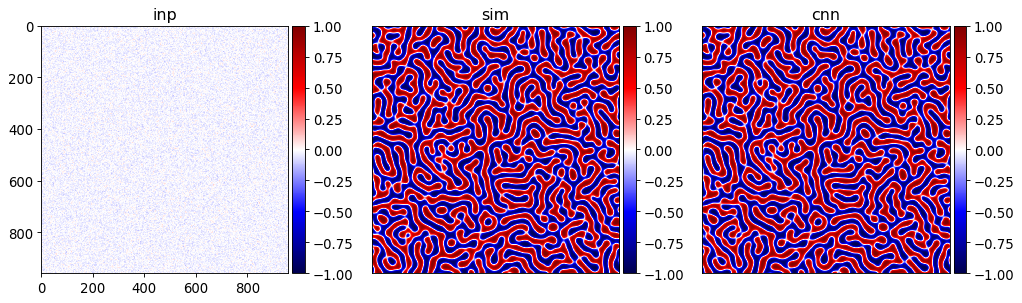

In [23]:
# device = torch.device("cpu:0")
# device = torch.device("cuda:0")

ix = 0

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)

prd = x1[:,0]

torch.cuda.empty_cache()
model.eval()
model.to(device)
for t in range(n_step):

    prd = model.unets[t](prd)

im_x1 = x1[0,0,0].detach().cpu().numpy()
im_y1 = y1[0,t,0].detach().cpu().numpy()
im_y2 = prd[0, 0].detach().cpu().numpy()
print("t: {}, mae: {:1.5f}".format(t, mae_loss(im_y1, im_y2)))
ch_utils.draw_by_side([im_x1, im_y1, im_y2], 
                      sub_titles=["inp", "sim", "cnn"], 
                      scale=8)

t: 4, mae: 0.03896


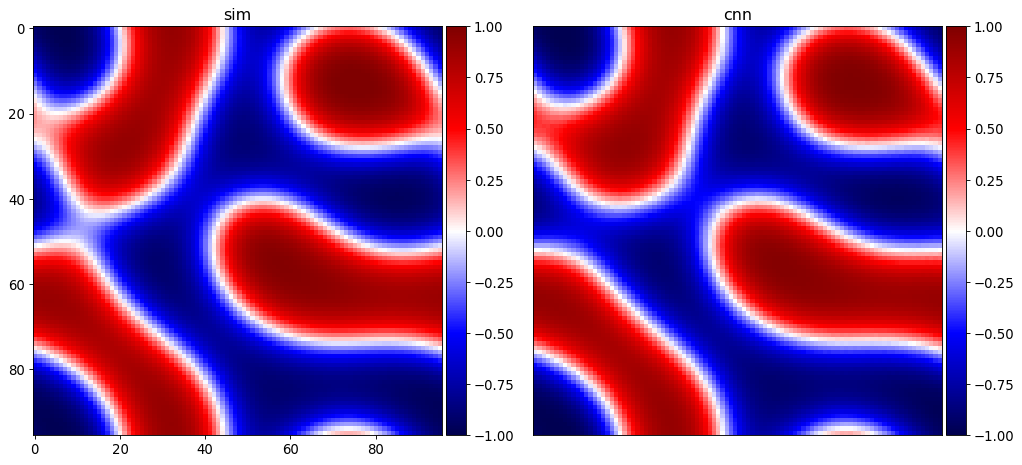

t: 4, mae: 0.01276


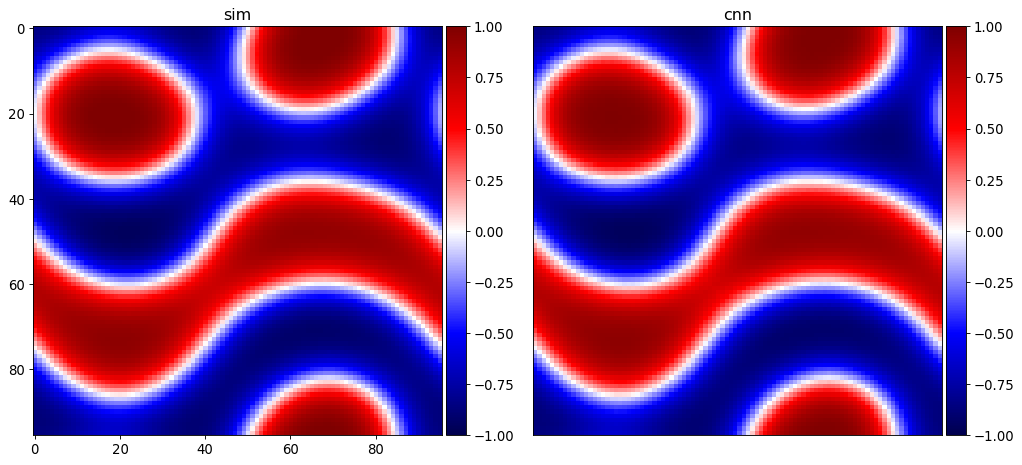

t: 4, mae: 0.01079


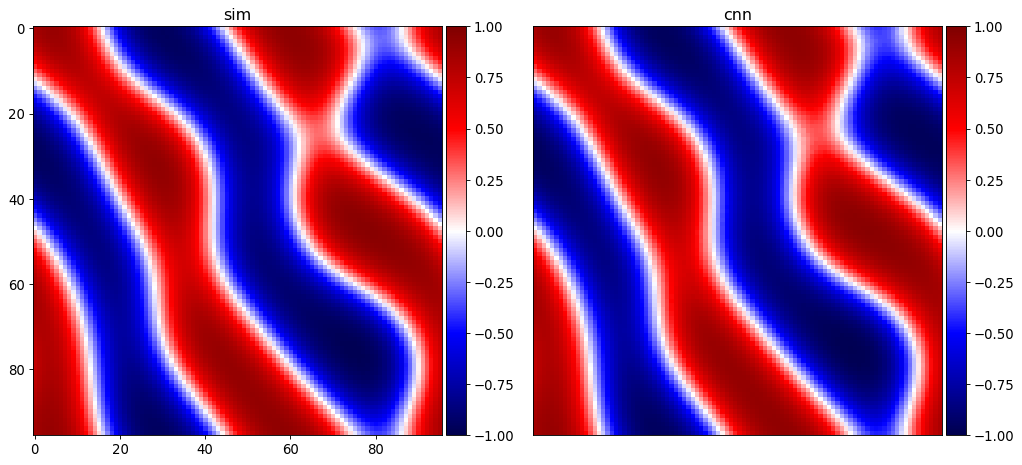

t: 4, mae: 0.00847


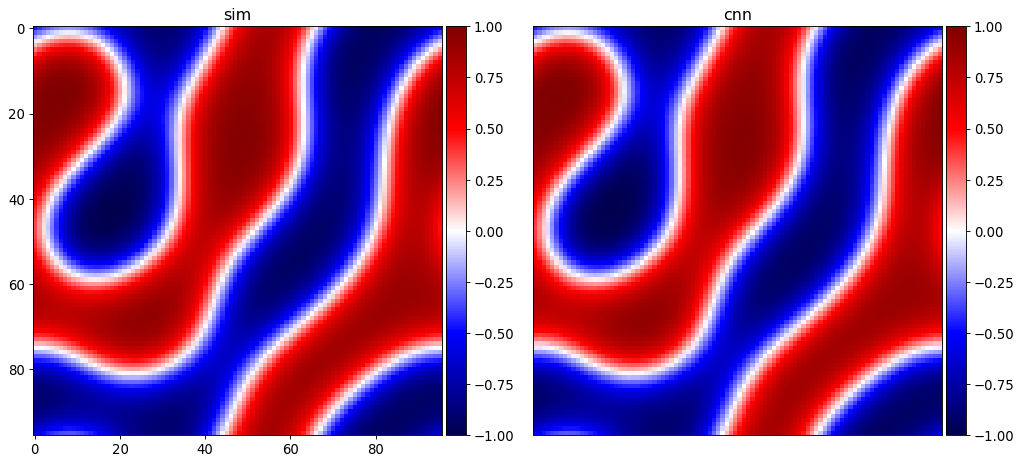

t: 4, mae: 0.00982


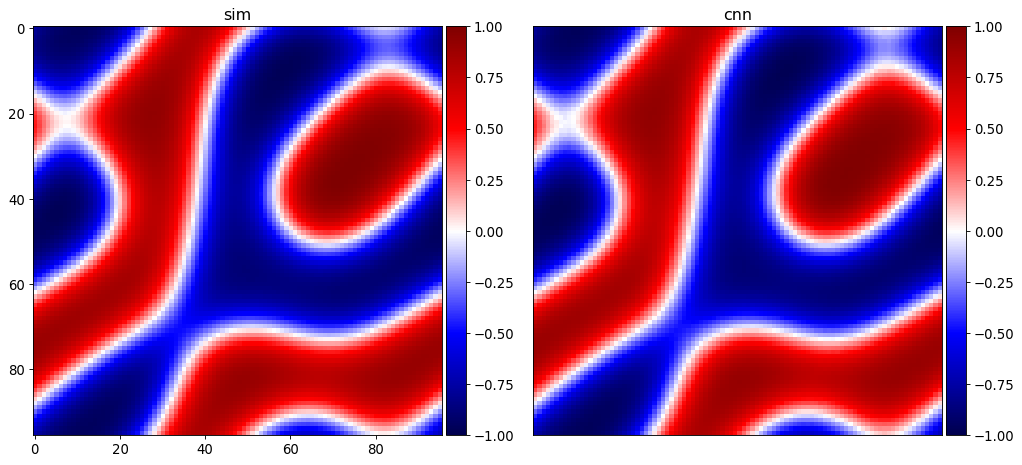

t: 4, mae: 0.02146


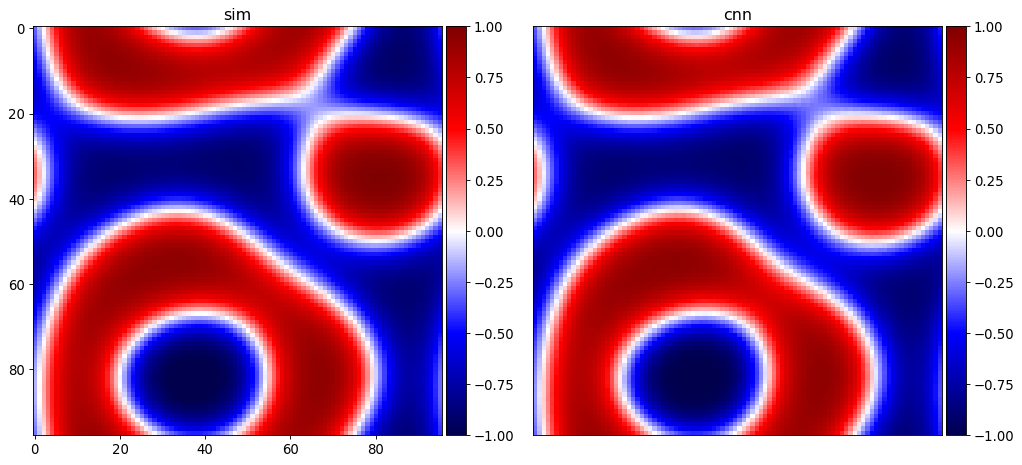

t: 4, mae: 0.00711


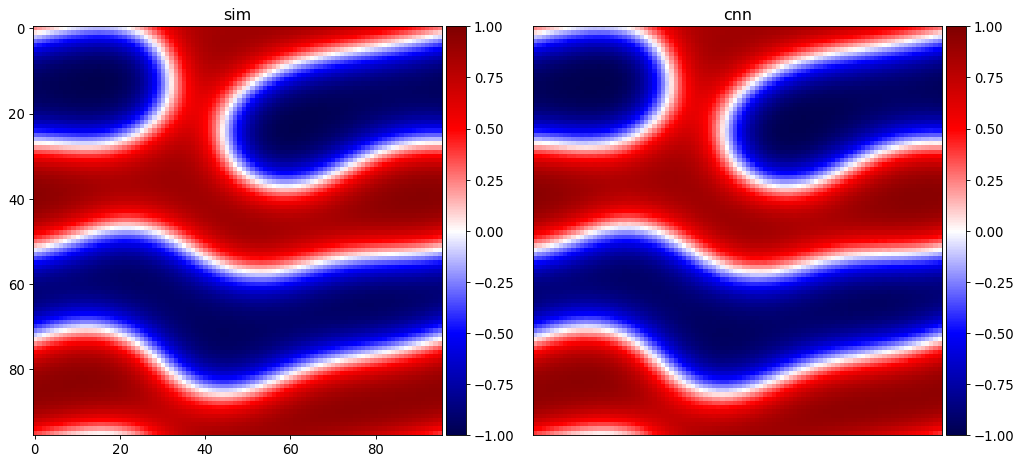

t: 4, mae: 0.00682


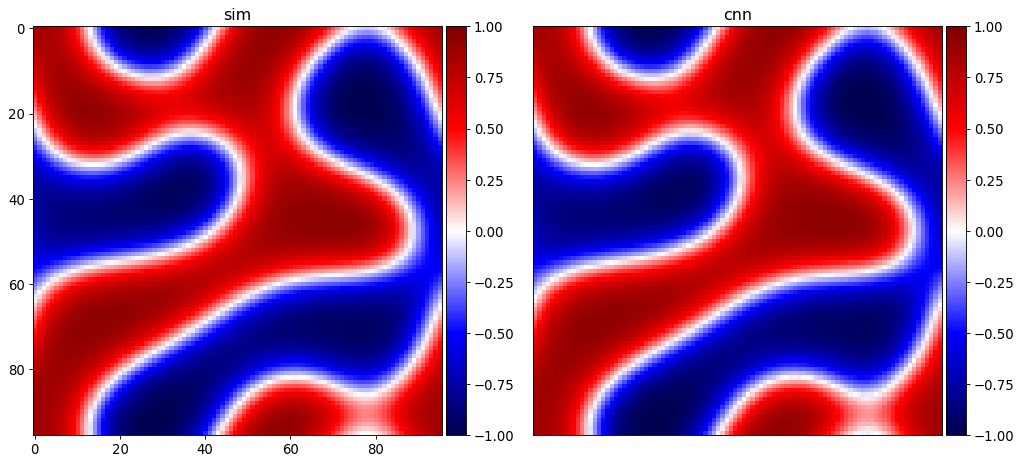

t: 4, mae: 0.02032


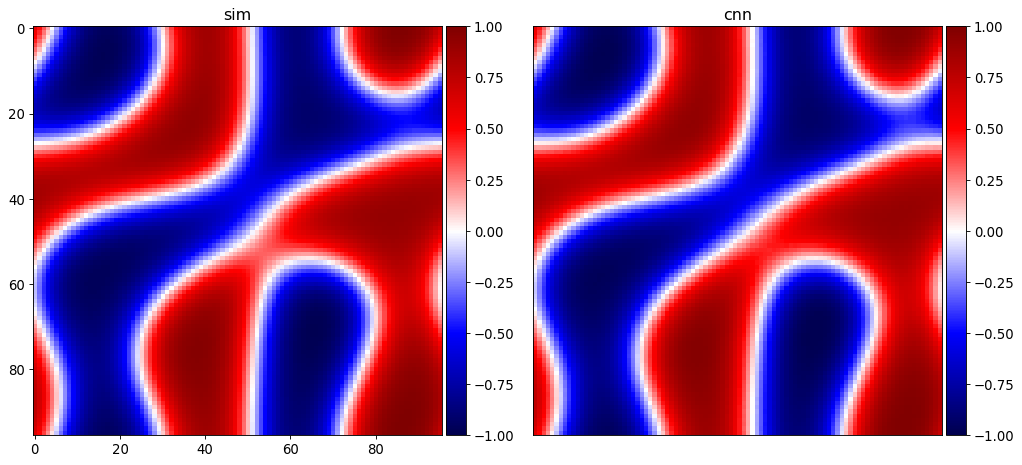

t: 4, mae: 0.00393


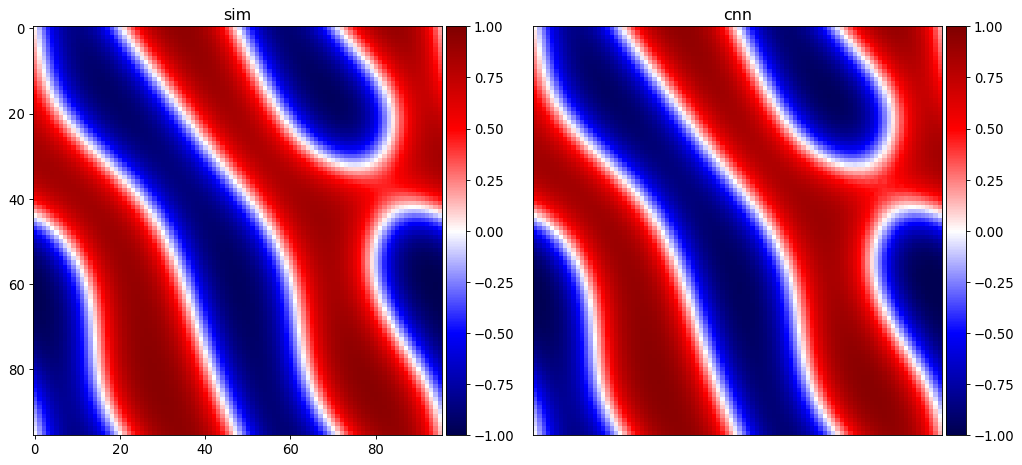

t: 4, mae: 0.01961


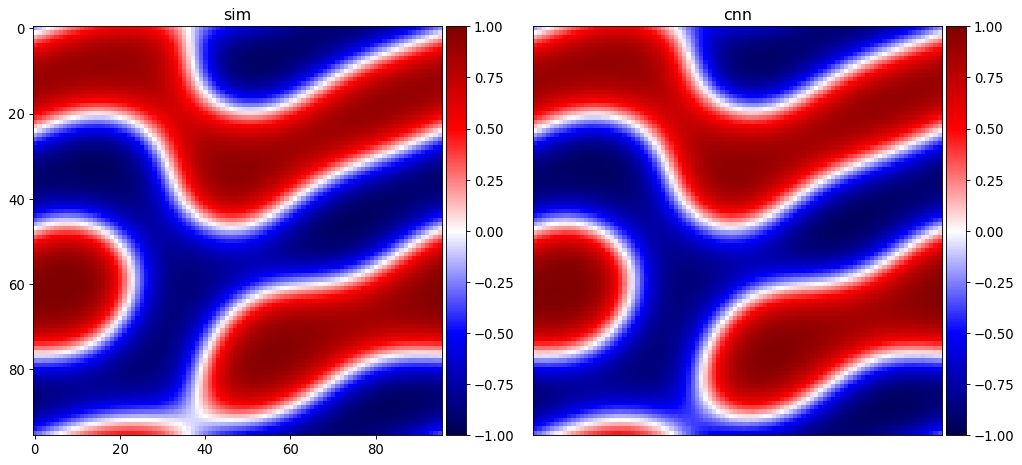

t: 4, mae: 0.01473


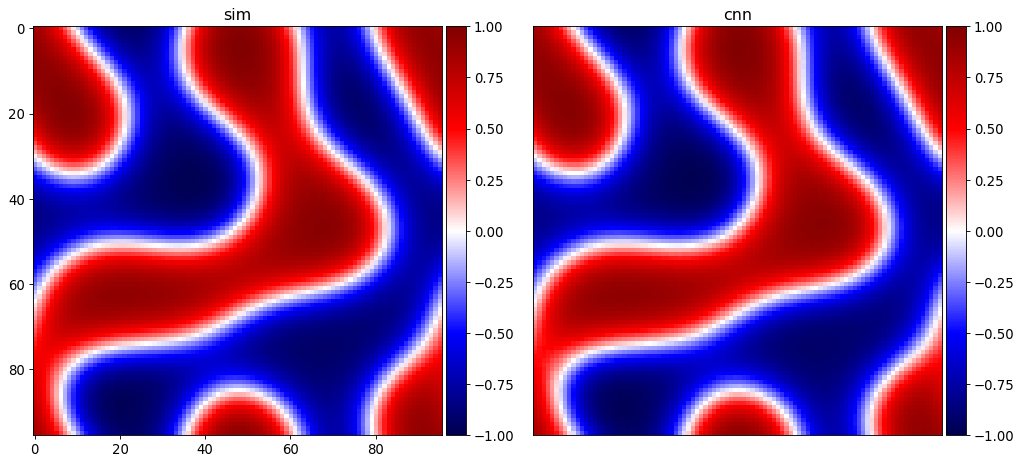

t: 4, mae: 0.00915


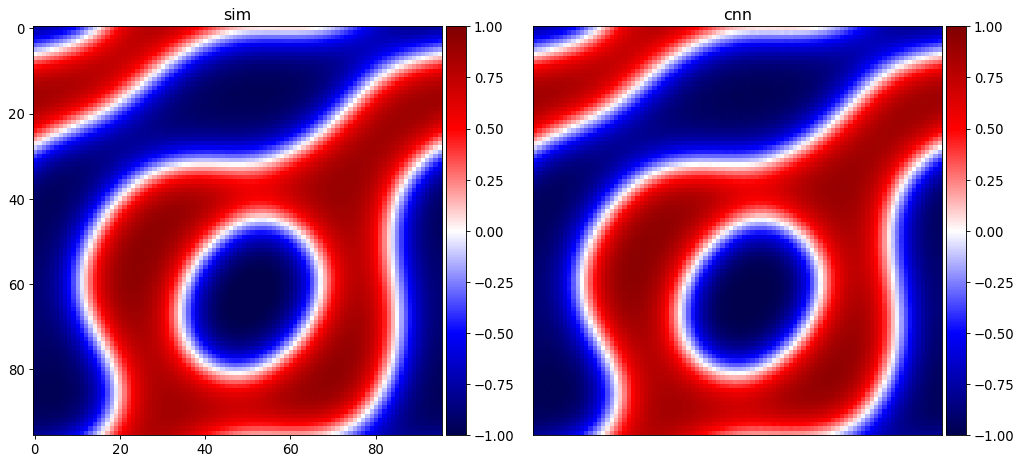

t: 4, mae: 0.00811


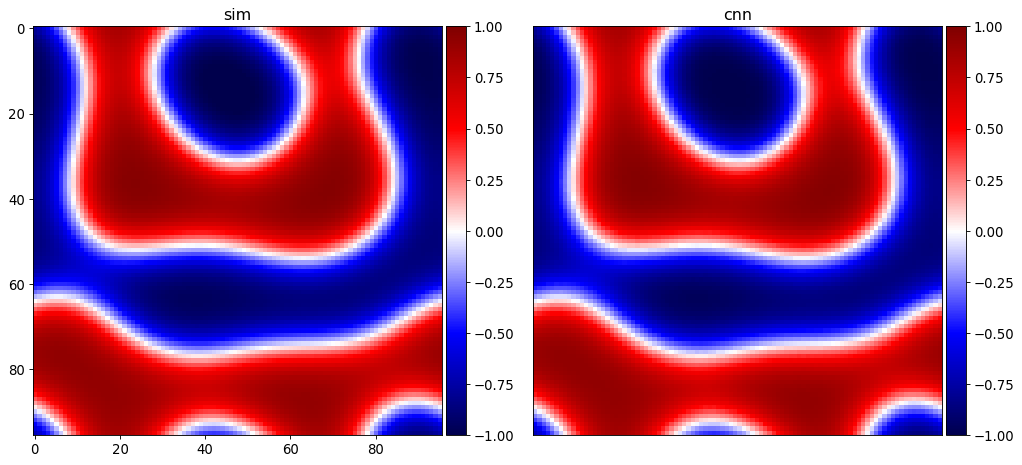

t: 4, mae: 0.01780


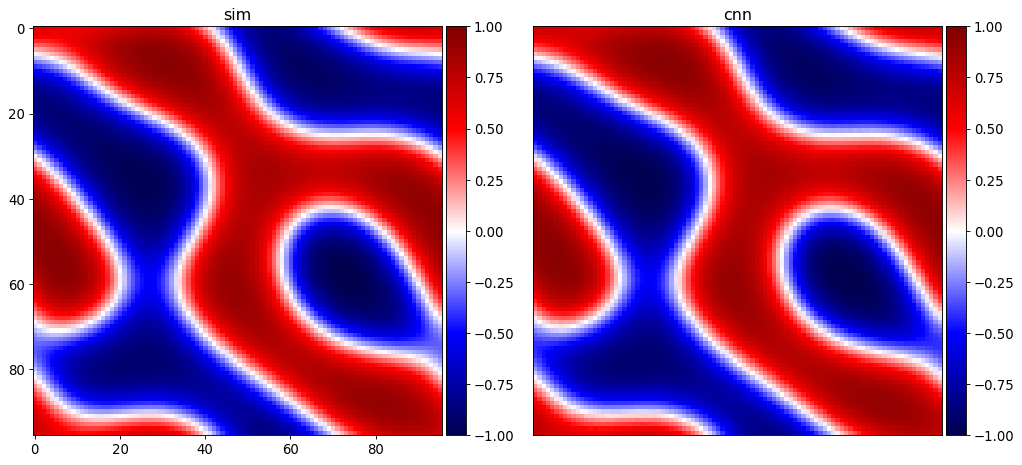

t: 4, mae: 0.02051


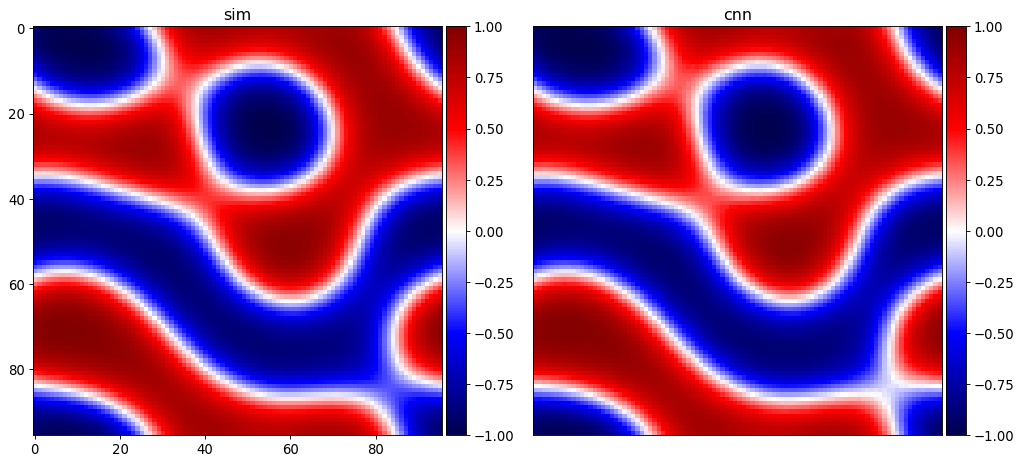

t: 4, mae: 0.01362


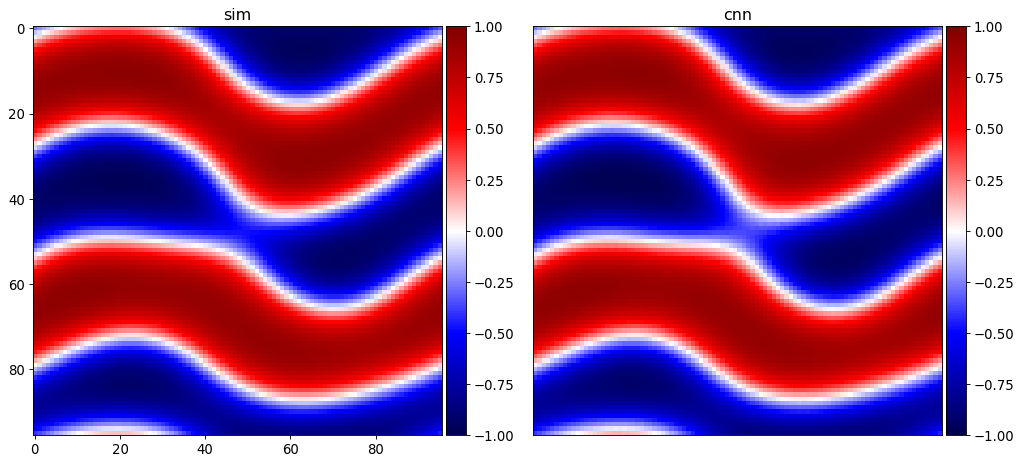

t: 4, mae: 0.01107


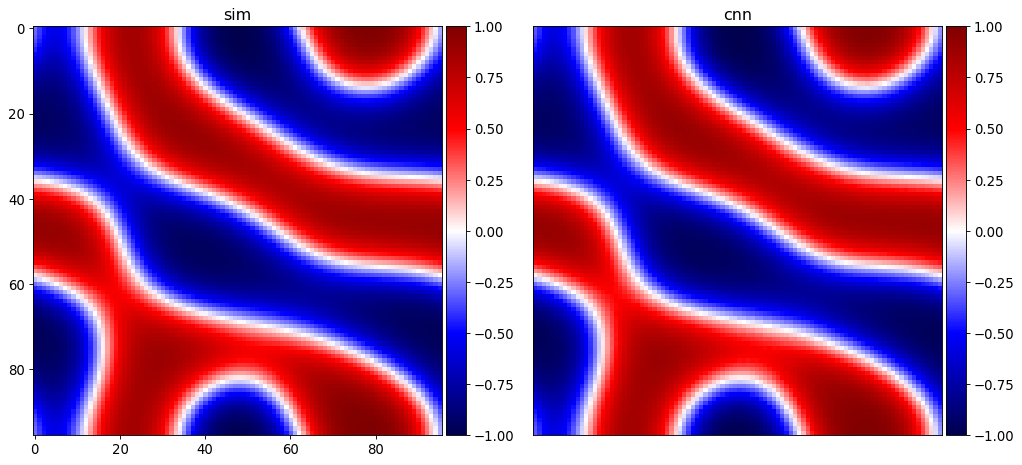

t: 4, mae: 0.01621


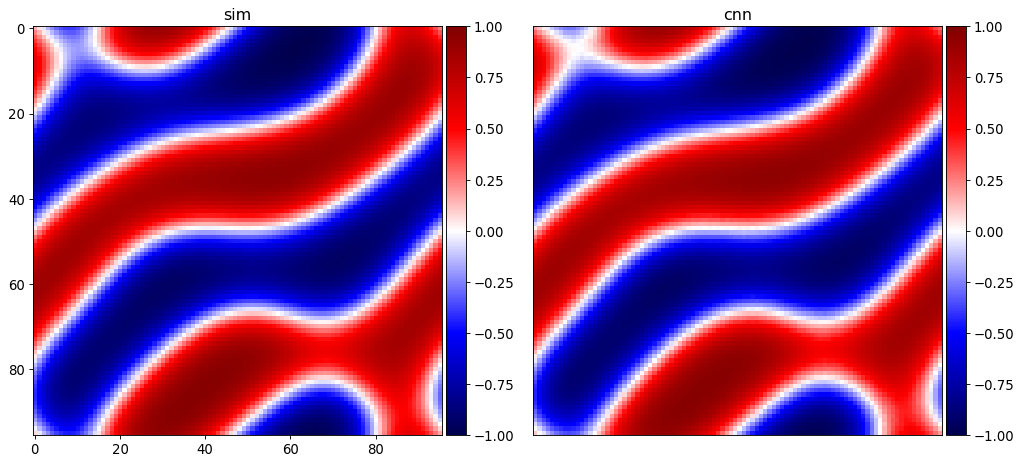

t: 4, mae: 0.01412


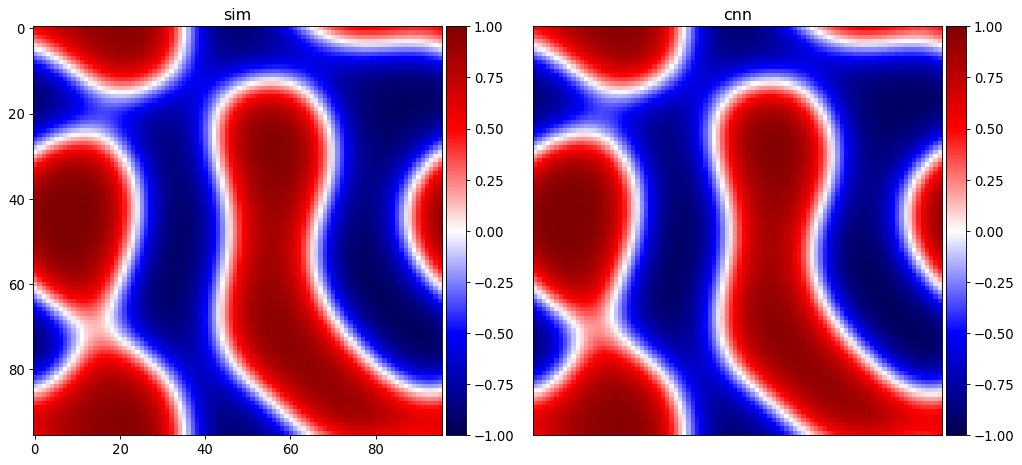

t: 4, mae: 0.00697


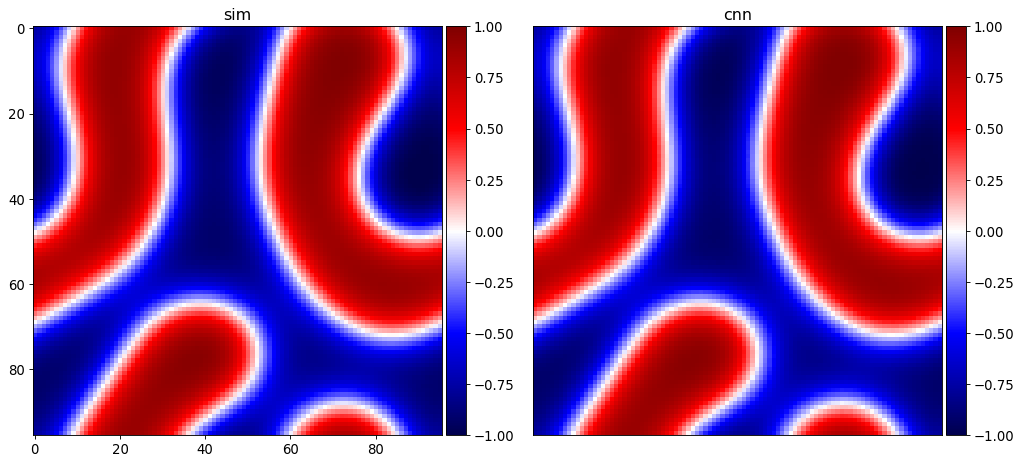

t: 4, mae: 0.00723


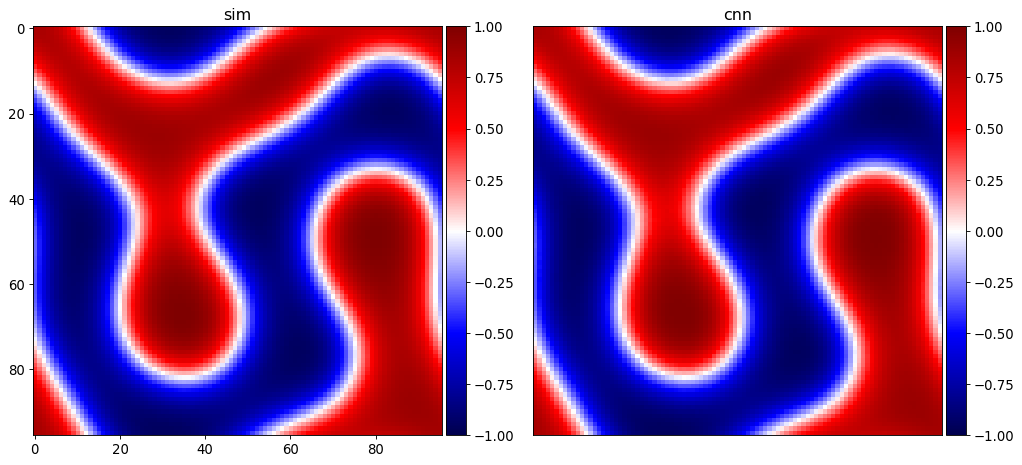

t: 4, mae: 0.02272


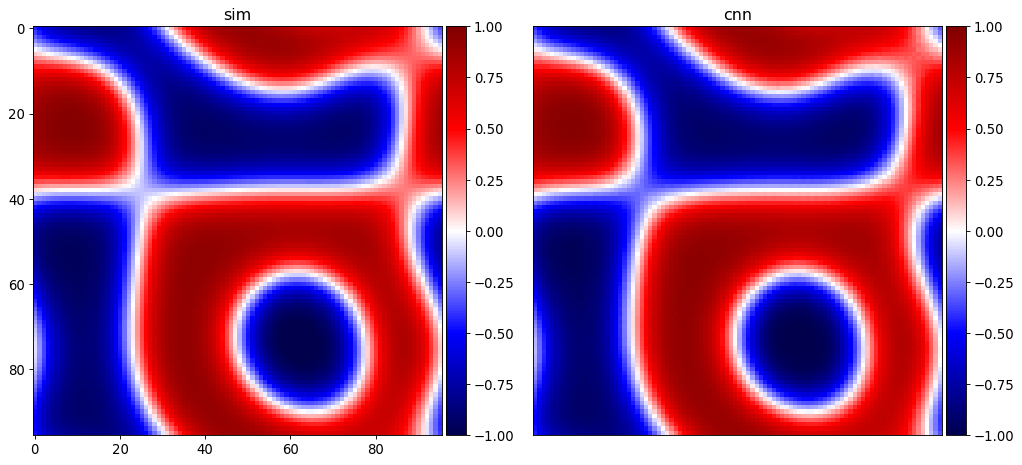

t: 4, mae: 0.02689


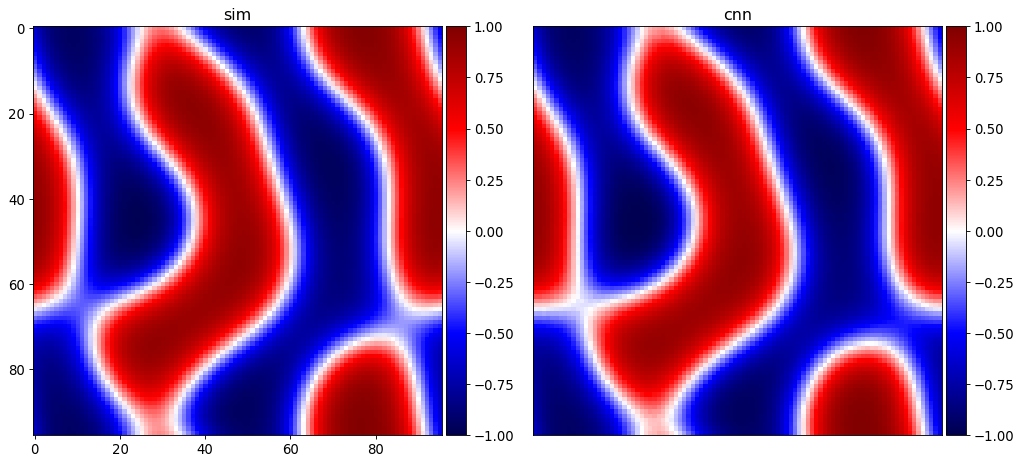

t: 4, mae: 0.01714


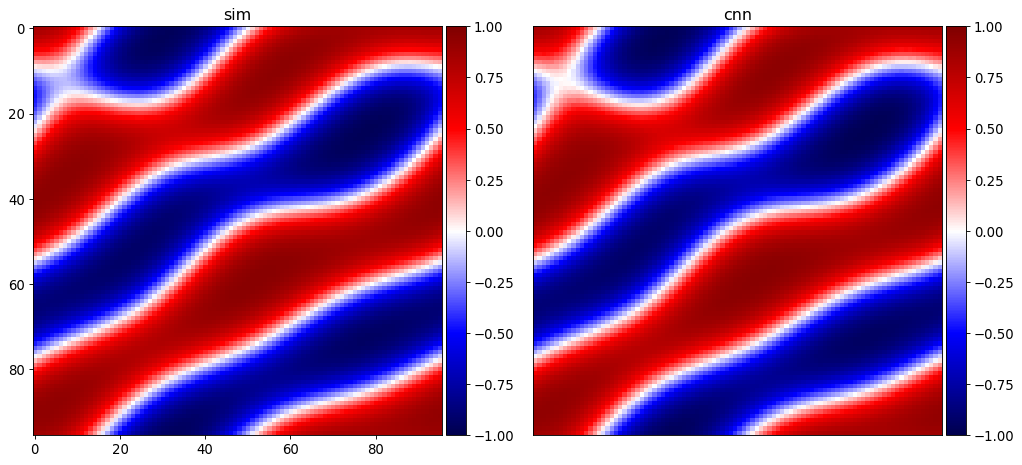

t: 4, mae: 0.00587


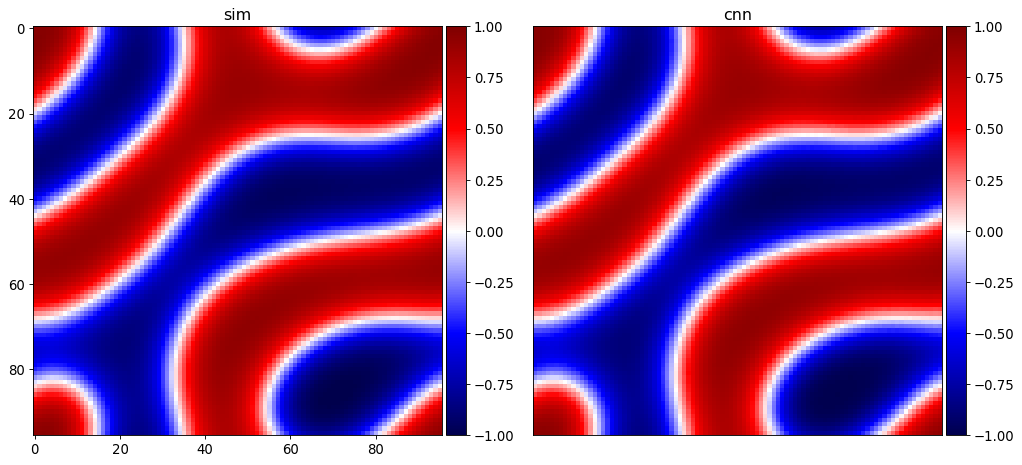

t: 4, mae: 0.01248


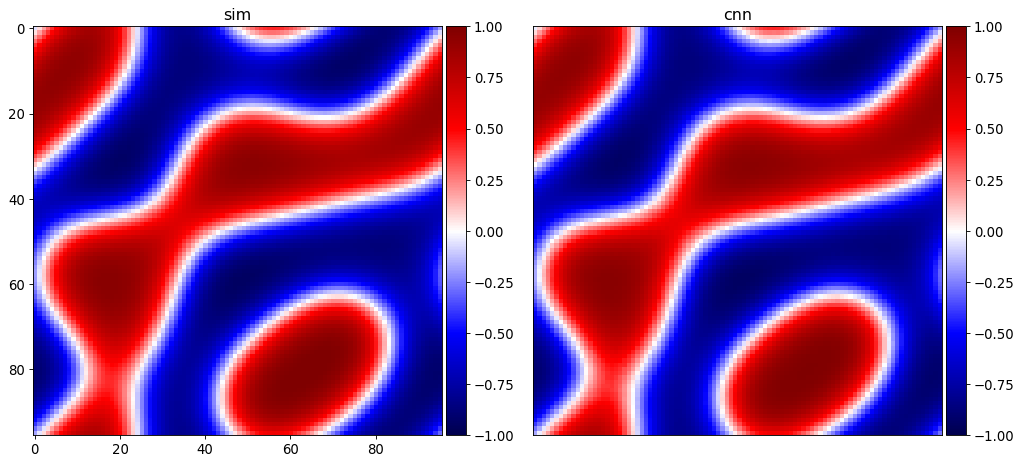

t: 4, mae: 0.01860


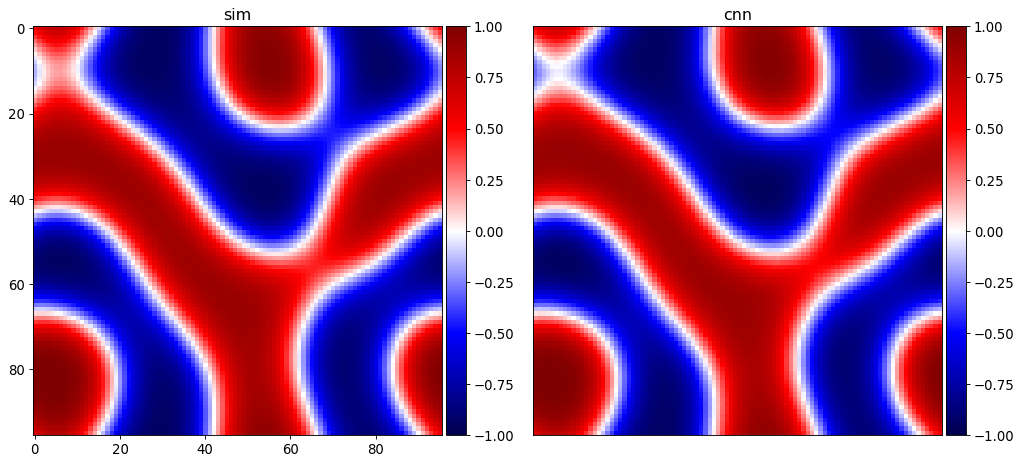

t: 4, mae: 0.00820


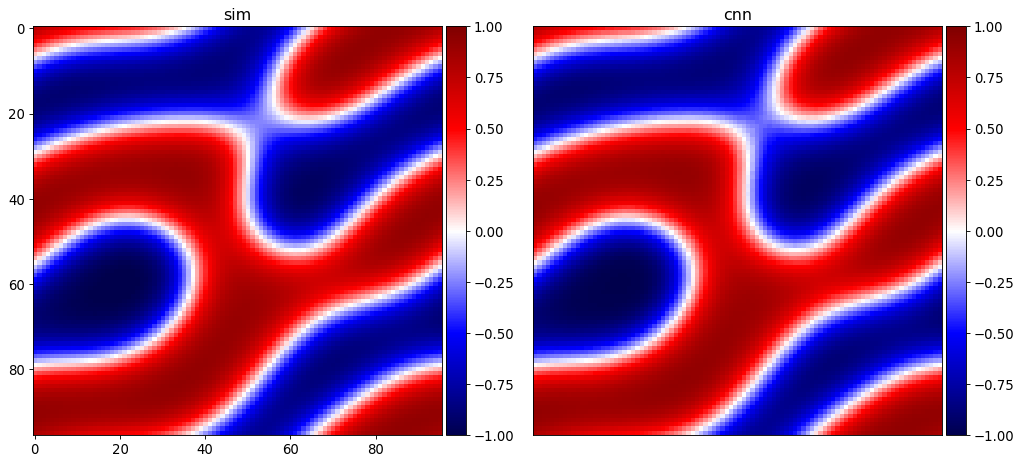

t: 4, mae: 0.00696


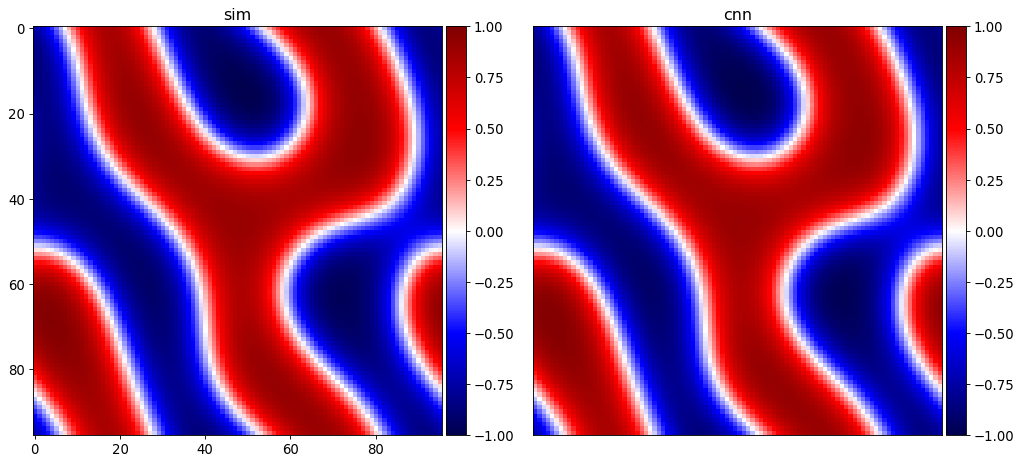

t: 4, mae: 0.01476


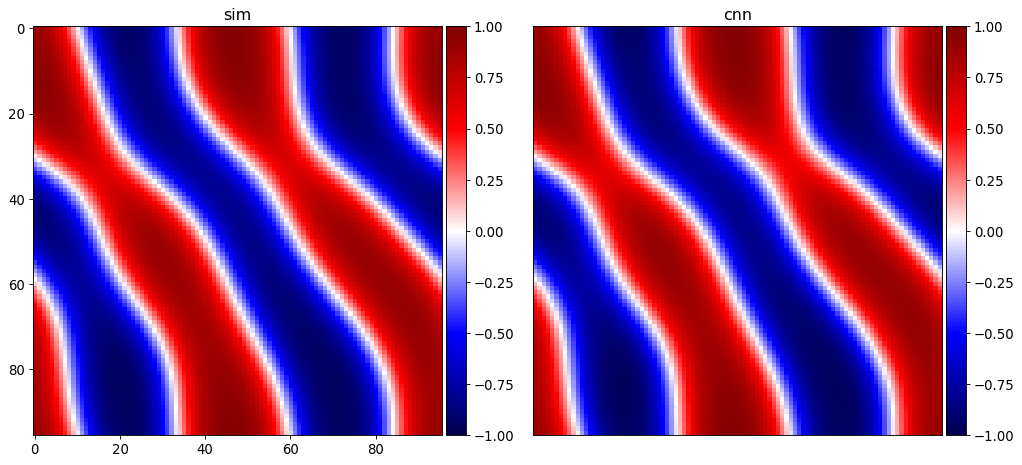

t: 4, mae: 0.00960


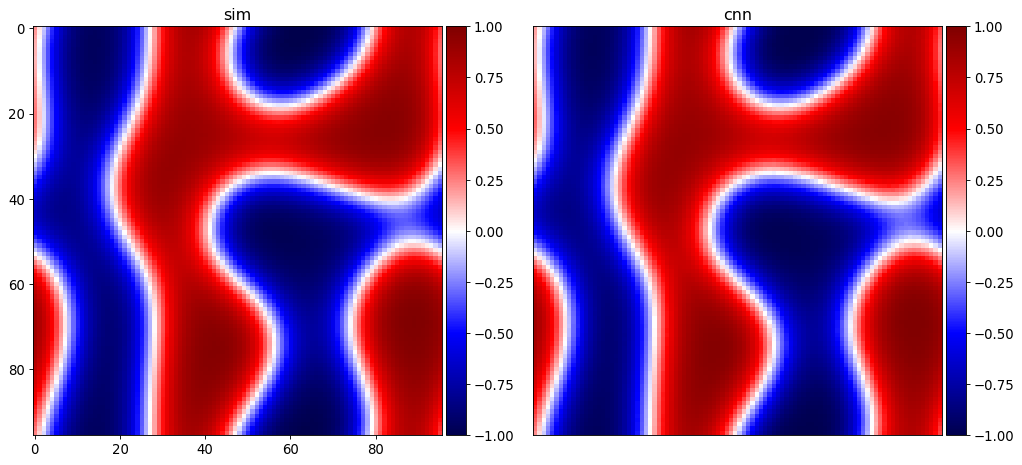

Mean err :0.01383733764686415, std: 0.007242733196967443


In [50]:
errs = []
for ix in range(len(val_dataset)):

    item_v = val_dataset[ix]
    x1 = item_v['x'][None].to(device)
    y1 = item_v['y'][None].to(device)

    prd = x1[:,0]

    torch.cuda.empty_cache()

    model.eval()
    model.to(device)
    for t in range(n_step):

        prd = model.unets[t](prd)
        im_y1 = y1[0,t,0].detach().cpu().numpy()
        im_y2 = prd[0, 0].detach().cpu().numpy()
    
    errs.append(mae_loss(im_y1, im_y2))
    print("t: {}, mae: {:1.5f}".format(t, errs[-1]))
    ch_utils.draw_by_side([im_y1, im_y2], 
                          sub_titles=["sim", "cnn"], 
                          scale=8)
    
print("Mean err :{}, std: {}".format(np.mean(errs), np.std(errs)))